In [1]:
#magic updater for imported libraries
import IPython
from IPython.display import display
IPython.get_ipython().run_line_magic('load_ext', 'autoreload')
IPython.get_ipython().run_line_magic('autoreload', '2')

#image displayer
from IPython.display import Image, display


import sys
import difflib
import keyword

#import env specific packages
#import primer3 as pr
from Levenshtein import distance as ld
from collections import Counter
from Bio.Seq import Seq
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

#file handling
from glob import glob
import os
import pickle
import argparse
import csv
import re

import datetime

#utilities & troubleshooting
import random
from tqdm import tqdm
import pprint as pp
import itertools
import math

#data_structures
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style(style='white') 

### Load chip sequences

In [2]:
paths_chip_proteins = glob("/home/audreyo/projects/mini_protein_library_seq/20220331_mp_lib_chip/20220425_protein_to_dna_chip/catted_fastas/*.fasta")

In [3]:
# make a dictionary of the library. sequence: library (e.g., 'HAHA' = tumor 2021)

chip_seq_dict = {}
for i in paths_chip_proteins:
    filename = str(i)
    file = open(i)
    file_lines = file.readlines()
    for line in file_lines:
        if line.startswith('M'):
            linestrip = line[:-1]
            filestrip = filename[-10:]
            chip_seq_dict[str(linestrip)] = filestrip[:-6]

### Enrichment function and compare organs

In [4]:
# Save counts per sequence --> dict_organ = sequence:counts

paths_rd3 = glob("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/NC_trimmed/*.fine")

ddict = {}
for i in paths_rd3:
    filename = str(i)
    file = open(i)
    file_lines = file.readlines()
    seq_list = []
    for line in file_lines:
        linestring=str(line)
        new_line = linestring.strip('\n')
        seq_list.append(new_line)
    ddict[filename[77:82]] = dict(Counter(seq_list))

In [5]:
paths_rd3 = glob("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/NC_trimmed/*.fine")

In [6]:
n_dict = {}
for i in ddict.keys():
    n_list = []
    subdict = ddict[i]
    for j in subdict.values():
        n_list.append(j)
    n_dict[i] = n_list

In [7]:
total_n_dict = {}
for i in n_dict:
    counter=0
    for j in n_dict[i]:
        counter+= j
    total_n_dict[str(i)]=counter

In [8]:
## Last update: 1/18/23

chg_score = {'I':0,'V':0,'L':0,'F':0,'C':0,'M':0,'A':0,'G':0,
                'T':0,'S':0,'Y':0,'W':0,'P':0,'H':+0.25,'E':-1,
                'Q':0,'D':-1,'N':0,'K':+1,'R':+1, 'X': 0, ',':0,
                '\n':0, ' ':0, '*':0, '"':0, 'X':0}
KD_hp_score = {'I':4.5,'V':4.2,'L':3.8,'F':2.8,'C':2.5,'M':1.9,'A':1.8,'G':-0.4,
                    'T':-0.7,'S':-0.8,'Y':-1.3,'W':-0.9,'P':-1.6,'H':-3.2,'E':-3.5,
                    'Q':-3.5,'D':-3.5,'N':-3.5,'K':-3.9,'R':-4.5, 'X': 0, ',':0,
                    '\n':0, ' ':0, '*':0, '"':0, 'X':0}

def enrich(test, baseline, read_cutoff):
    enrich_list = []
    enrich_f_dict={}
    # loop through dictionary of organ: sequence: count 
    for i in ddict[test]:
        seq = str(i)
        lenseq = len(seq)
        # get total counts per sample from n_dict
        n_i = float(total_n_dict[baseline])
        n_f = float(total_n_dict[test])
        # get counts per specific sequence from ddict
        count_f = ddict[test][i]
        # if the sequence wasn't detected in baseline, assign read_cutoff
        if count_f >= read_cutoff:
            try: 
                count_i = ddict[baseline][i]
            except:
                count_i = 0
            # enrichment as proportion of specific sequence reads over total reads per sample (representation)
            # added this in on 9/16
            if count_i >= read_cutoff: 
                enrich = (float(count_f)/n_f)/(float(count_i)/n_i)
                enrich_list.append(enrich)
                chg_count = 0
                hp_score = 0
                protein = IP(str(i))
                pI = protein.charge_at_pH(7.4)
                for letter in i:
                    chg_count += chg_score[letter]    
                    hp_score += KD_hp_score[letter]
                chg_vs_len = float(chg_count)/float(lenseq)
                hp_vs_len = float(hp_score)/float(lenseq)
                # if it's long enough, enriched (>1), and has enough reads, add it to the dictionary
                if len(i) > 30: # and enrich > 1:
                    enrich_f_dict[i] = [count_i, count_f, enrich, chg_count, hp_score, chg_vs_len, hp_vs_len, pI, np.log10(enrich)]

    enrich_f_df = pd.DataFrame.from_dict(enrich_f_dict)
    enrich_f_df = pd.DataFrame.transpose(enrich_f_df)
    enrich_f_df = enrich_f_df.rename(columns={0: "count_i", 1: "count_f", 2: "enrich",3:"charge", 4:"hp", 5:"chg_vs_len",6:"hp_vs_len", 7:"pI at pH 7.4", 8:"log_enrich"})

    return (enrich_f_dict, enrich_f_df)


In [9]:
# hel means from healthy mice
# tum means from tumor mice
# ten means from mouse 10

# 0: "enrich", 1:"log_enrich", 2:"representation"

helbr_enrich_dict,  helbr_enrich_df = enrich('01-br', '33-ds', 5)
tumbr_enrich_dict,  tumbr_enrich_df = enrich('02-br', '33-ds', 5)
tenbr_enrich_dict,  tenbr_enrich_df = enrich('03-br', '33-ds', 5)
helhe_enrich_dict,  helhe_enrich_df = enrich('04-he', '33-ds', 5)
tumhe_enrich_dict,  tumhe_enrich_df = enrich('05-he', '33-ds', 5)
tenhe_enrich_dict,  tenhe_enrich_df = enrich('06-he', '33-ds', 5)
helki_enrich_dict,  helki_enrich_df = enrich('07-ki', '33-ds', 5)
tumki_enrich_dict,  tumki_enrich_df = enrich('08-ki', '33-ds', 5)
tenki_enrich_dict,  tenki_enrich_df = enrich('09-ki', '33-ds', 5)
helli_enrich_dict,  helli_enrich_df = enrich('10-li', '33-ds', 5)
tumli_enrich_dict,  tumli_enrich_df = enrich('11-li', '33-ds', 5)
tenli_enrich_dict,  tenli_enrich_df = enrich('12-li', '33-ds', 5)
hellu_enrich_dict,  hellu_enrich_df = enrich('13-lu', '33-ds', 5)
tumlu_enrich_dict,  tumlu_enrich_df = enrich('14-lu', '33-ds', 5)
helsp_enrich_dict,  helsp_enrich_df = enrich('16-sp', '33-ds', 5)
tumsp_enrich_dict,  tumsp_enrich_df = enrich('17-sp', '33-ds', 5)
tensp_enrich_dict,  tensp_enrich_df = enrich('18-sp', '33-ds', 5)
tumtu_enrich_dict,  tumtu_enrich_df = enrich('19-tu', '33-ds', 5)
helTA_enrich_dict,  helTA_enrich_df = enrich('20-TA', '33-ds', 5)
tumTA_enrich_dict,  tumTA_enrich_df = enrich('21-TA', '33-ds', 5)
tenTA_enrich_dict,  tenTA_enrich_df = enrich('22-TA', '33-ds', 5)
helga_enrich_dict,  helga_enrich_df = enrich('23-ga', '33-ds', 5)
tumga_enrich_dict,  tumga_enrich_df = enrich('24-ga', '33-ds', 5)
tenga_enrich_dict,  tenga_enrich_df = enrich('25-ga', '33-ds', 5)
helso_enrich_dict,  helso_enrich_df = enrich('26-so', '33-ds', 5)
tumso_enrich_dict,  tumso_enrich_df = enrich('27-so', '33-ds', 5)
tenso_enrich_dict,  tenso_enrich_df = enrich('28-so', '33-ds', 5)
heldi_enrich_dict,  heldi_enrich_df = enrich('29-di', '33-ds', 5)
tumdi_enrich_dict,  tumdi_enrich_df = enrich('30-di', '33-ds', 5)
tendi_enrich_dict,  tendi_enrich_df = enrich('31-di', '33-ds', 5)

helbh_enrich_dict,  helbh_enrich_df = enrich('34-bh', '33-ds', 5)
tumbt_enrich_dict,  tumbt_enrich_df = enrich('35-bt', '33-ds', 5)

helpb_enrich_dict, helpb_enrich_df = enrich('32-pb', '33-ds', 5)

In [36]:

# brains
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helbr_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helbr_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumbr_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumbr_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenbr_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenbr_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# hearts   
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helhe_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helhe_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumhe_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumhe_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenhe_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenhe_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

# kidneys
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helki_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helki_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumki_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumki_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenki_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenki_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# livers    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helli_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helli_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumli_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumli_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenli_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenli_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# lungs    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            hellu_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(hellu_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumlu_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumlu_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
# spleens    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helsp_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helsp_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumsp_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumsp_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tensp_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tensp_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# tumor    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumtu_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumtu_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    


    
    
# TA    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helTA_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helTA_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumTA_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumTA_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenTA_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenTA_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

# ga
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helga_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helga_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumga_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumga_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenga_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenga_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# so    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helso_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helso_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumso_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumso_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tenso_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tenso_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# di
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            heldi_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(heldi_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumdi_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumdi_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tendi_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tendi_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
# bloods and PBMCs
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helbh_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helbh_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            tumbt_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(tumbt_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220914_rd_3_pickles/ \
            helpb_enrich_dict.pickle', 'wb') as handle:
    pickle.dump(helpb_enrich_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
organ_dict_list = [helbr_enrich_dict, tumbr_enrich_dict,tenbr_enrich_dict,helhe_enrich_dict,tumhe_enrich_dict,tenhe_enrich_dict,helki_enrich_dict,tumki_enrich_dict,\
                   tenki_enrich_dict, helli_enrich_dict,tumli_enrich_dict,tenli_enrich_dict,hellu_enrich_dict,tumlu_enrich_dict,helsp_enrich_dict,tumsp_enrich_dict,tensp_enrich_dict,\
                   tumtu_enrich_dict,helTA_enrich_dict,tumTA_enrich_dict,tenTA_enrich_dict,helga_enrich_dict,tumga_enrich_dict,tenga_enrich_dict,helso_enrich_dict,tumso_enrich_dict,\
                   tenso_enrich_dict,heldi_enrich_dict,tumdi_enrich_dict,tendi_enrich_dict,helbh_enrich_dict,tumbt_enrich_dict,helpb_enrich_dict]

In [11]:
# usage: (dict, df) = add_all_organs_to_enrich_df(input_df)
# input_df: columns = from enrich function. CHECK LINE BELOW

# gives log enrich
def add_all_organs_to_enrich_df(input_df):
    
    all_organ_enrich_hits_dict = {}
    
    # this should be the order of the enrichment values for each sequence
    organ_dict_list = [helbr_enrich_dict, tumbr_enrich_dict,tenbr_enrich_dict,helhe_enrich_dict,tumhe_enrich_dict,tenhe_enrich_dict,helki_enrich_dict,tumki_enrich_dict,\
                   tenki_enrich_dict, helli_enrich_dict,tumli_enrich_dict,tenli_enrich_dict,hellu_enrich_dict,tumlu_enrich_dict,helsp_enrich_dict,tumsp_enrich_dict,tensp_enrich_dict,\
                   tumtu_enrich_dict,helTA_enrich_dict,tumTA_enrich_dict,tenTA_enrich_dict,helga_enrich_dict,tumga_enrich_dict,tenga_enrich_dict,helso_enrich_dict,tumso_enrich_dict,\
                   tenso_enrich_dict,heldi_enrich_dict,tumdi_enrich_dict,tendi_enrich_dict,helbh_enrich_dict,tumbt_enrich_dict,helpb_enrich_dict]
    
    # for every sequence in the input dataframe:
    for i in input_df.index:
        # make an entry in the dictionary as a blank list
        all_organ_enrich_hits_dict[i] = []
        
        # for every organ_enrich_dict:
        for j in organ_dict_list:
            try: 
                # append the list with the log10 enrich value for this sequence in this organ
                # DOUBLE CHECK THIS!!
                all_organ_enrich_hits_dict[i].append(j[i][8])
            except:
                all_organ_enrich_hits_dict[i].append(0)
    
    all_organ_enrich_hits_df = pd.DataFrame.from_dict(all_organ_enrich_hits_dict)
    all_organ_enrich_hits_df = all_organ_enrich_hits_df.transpose()

    # rename the columns in the same order as the organ_dict_list
    all_organ_enrich_hits_df = all_organ_enrich_hits_df.rename(columns = {0: "H Brain", 1: "T Brain", 2: "H Brain - 1hr", 
                                                     3: "H Heart", 4: "T Heart", 5: "H Heart - 1hr",
                                                     6: "H Kidney", 7: "T Kidney", 8: "H Kidney - 1hr",
                                                     9: "H Liver", 10: "T Liver", 11: "H Liver - 1hr",
                                                     12: "H Lungs", 13: "T Lungs", 
                                                     14: "H Spleen", 15: "T Spleen", 16: "H Spleen - 1hr", 
                                                     17: "T Tumor", 
                                                     18: "H TA", 19: "T TA", 20: "H TA - 1hr",
                                                     21: "H GA", 22: "T GA", 23: "H GA - 1hr", 
                                                     24: "H So", 25: "T So", 26: "H So - 1hr",
                                                     27: "H Di", 28: "T Di", 29: "H Di - 1hr",
                                                     30: "H Blood", 31: "T Blood", 32: "H PBMC"})
    
    return(all_organ_enrich_hits_dict, all_organ_enrich_hits_df)

In [13]:
#spot check
tumtu_enrich_all_df

H Brain   T Brain  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.067708  0.441672   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS        0.000000  0.000000   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.000000  0.000000   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.000000  0.000000   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG        0.000000  0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000  0.238011   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.555307  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.000000  0.000000   

                                                    H Brain - 1hr   H Heart  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                0.000000 -0.526739   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             0.267337 -0.117594   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             0.000000 -0.070883   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      0.522235 -0.059602   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS                    0.000000  0.560187   
...                                                           ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG             0.590204 -0.342149   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...       0.000000  0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE             0.000000 -0.296391   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG              0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG                   0.000000  0.082370   

                                                     T Heart  H Heart - 1hr  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN          -0.216672      -0.593821   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.486294      -0.192502   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.382034       0.513975   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.258433       0.071616   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000       0.078565   
...                                                      ...            ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.291719       0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000       0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.000000       0.097048   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000       0.659436   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG             -0.136046      -0.483232   

                                                    H Kidney  T Kidney  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.002492 -0.076144   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.000119 -0.178275   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.150056 -0.185008   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.374697  0.071603   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.057612  0.169267   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.073667  0.150784   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE       -0.032788  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.107091 -0.133213   

                                                    H Kidney - 1hr   H Liver  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                 0.009233  0.036919   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             -0.207143  0.118780   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             -0.100576  0.208957   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      

In [77]:
#spot check
tumki_enrich_dict['MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS'][1]

-0.17827463700149254

In [12]:
# usage: (dict, df) = add_all_organs_to_enrich_df(input_df)
# input_df: columns={0: "enrich", 1:"log_enrich", 2:"representation"}

# gives raw (not log) enrich
def add_all_organs_to_raw_enrich_df(input_df):
    all_organ_enrich_hits_dict = {}
    for i in input_df.index:
        all_organ_enrich_hits_dict[i] = []
        for j in organ_dict_list:
            try: 
                all_organ_enrich_hits_dict[i].append(j[i][0])
            except:
                all_organ_enrich_hits_dict[i].append(0)
    all_organ_enrich_hits_df = pd.DataFrame.from_dict(all_organ_enrich_hits_dict)
    all_organ_enrich_hits_df = all_organ_enrich_hits_df.transpose()

    all_organ_enrich_hits_df = all_organ_enrich_hits_df.rename(columns = {0: "H Brain", 1: "T Brain", 2: "H Brain - 1hr", 
                                                     3: "H Heart", 4: "T Heart", 5: "H Heart - 1hr",
                                                     6: "H Kidney", 7: "T Kidney", 8: "H Kidney - 1hr",
                                                     9: "H Liver", 10: "T Liver", 11: "H Liver - 1hr",
                                                     12: "H Lungs", 13: "T Lungs", 
                                                     14: "H Spleen", 15: "T Spleen", 16: "H Spleen - 1hr", 
                                                     17: "T Tumor", 
                                                     18: "H TA", 19: "T TA", 20: "H TA - 1hr",
                                                     21: "H GA", 22: "T GA", 23: "H GA - 1hr", 
                                                     24: "H So", 25: "T So", 26: "H So - 1hr",
                                                     27: "H Di", 28: "T Di", 29: "H Di - 1hr",
                                                     30: "H Blood", 31: "T Blood", 32: "H PBMC"})
    return(all_organ_enrich_hits_dict, all_organ_enrich_hits_df)

In [13]:
# usage: (dict, df) = add_all_organs_to_enrich_df(input_df)
# input_df: columns={0: "enrich", 1:"log_enrich", 2:"representation"}

def add_all_organs_to_representation_df(input_df):
    all_organ_rep_hits_dict = {}
    for i in input_df.index:
        all_organ_rep_hits_dict[i] = []
        for j in organ_dict_list:
            try: 
                all_organ_rep_hits_dict[i].append(j[i][2])
            except:
                all_organ_rep_hits_dict[i].append(0)
    all_organ_rep_hits_df = pd.DataFrame.from_dict(all_organ_rep_hits_dict)
    #all_organ_rep_hits_df = all_organ_rep_hits_df.transpose()

    all_organ_rep_hits_df = all_organ_rep_hits_df.rename(rows = {0: "H Brain", 1: "T Brain", 2: "H Brain - 1hr", 
                                                     3: "H Heart", 4: "T Heart", 5: "H Heart - 1hr",
                                                     6: "H Kidney", 7: "T Kidney", 8: "H Kidney - 1hr",
                                                     9: "H Liver", 10: "T Liver", 11: "H Liver - 1hr",
                                                     12: "H Lungs", 13: "T Lungs", 
                                                     14: "H Spleen", 15: "T Spleen", 16: "H Spleen - 1hr", 
                                                     17: "T Tumor", 
                                                     18: "H TA", 19: "T TA", 20: "H TA - 1hr",
                                                     21: "H GA", 22: "T GA", 23: "H GA - 1hr", 
                                                     24: "H So", 25: "T So", 26: "H So - 1hr",
                                                     27: "H Di", 28: "T Di", 29: "H Di - 1hr",
                                                     30: "H Blood", 31: "T Blood", 32: "H PBMC"})
    return(all_organ_rep_hits_dict, all_organ_rep_hits_df)

### 202212_All seq in all organs df to csv

In [114]:
# enrich dictionary values={0: "enrich", 1:"log_enrich", 2:"representation"})



organ_dict_list = [helbr_enrich_dict, tumbr_enrich_dict,tenbr_enrich_dict,
                   helhe_enrich_dict,tumhe_enrich_dict,tenhe_enrich_dict,
                   helki_enrich_dict,tumki_enrich_dict,tenki_enrich_dict, 
                   helli_enrich_dict,tumli_enrich_dict,tenli_enrich_dict,
                   hellu_enrich_dict,tumlu_enrich_dict,
                   helsp_enrich_dict,tumsp_enrich_dict,tensp_enrich_dict,\
                   tumtu_enrich_dict,helTA_enrich_dict,tumTA_enrich_dict,tenTA_enrich_dict,helga_enrich_dict,tumga_enrich_dict,tenga_enrich_dict,helso_enrich_dict,tumso_enrich_dict,\
                   tenso_enrich_dict,heldi_enrich_dict,tumdi_enrich_dict,tendi_enrich_dict,helbh_enrich_dict,tumbt_enrich_dict,helpb_enrich_dict]

unique_key_list = []
# add all sequences to list
for i in organ_dict_list:
    keys = i.keys()
    for j in keys:
        if j not in unique_key_list:
            unique_key_list.append(j)
    
log_enrich_all_dict = {}
# all_dict = {sequence:[helbr, tumbr, ...] ...} for all sequnces. in log enrich.
# for each unique key, get log enrichment for every sequence in every organ, else 0

for k in unique_key_list:

    log_enrich_all_dict[k] = []
    
for d in organ_dict_list:
    for k in unique_key_list:
        try:
            log_enrich_all_dict[k].append(d[k][1])
        except: 
            log_enrich_all_dict[k].append(0)
        
    

In [77]:
len(organ_dict_list)

33

In [115]:
log_enrich_all_df = pd.DataFrame.from_dict(log_enrich_all_dict) #, columns=log_enrich_all_dict.keys())
log_enrich_all_df.columns = log_enrich_all_dict.keys()
#log_enrich_all_df = log_enrich_all_df.transpose()

log_enrich_all_df.index=['hel_br', 'tum_br','hhr_br',
                           'hel_he','tum_he','hhr_he',
                           'hel_ki','tum_ki','hhr_ki', 
                           'hel_li','tum_li','hhr_li',
                           'hel_lu','tum_lu',
                           'hel_sp','tum_sp','hhr_sp',
                           'tum_tu',
                           'hel_ta', 'tum_ta', 'hhr_ta',
                           'hel_ga','tum_ga','hhr_ga',
                           'hel_so','tum_so','hhr_so',
                           'hel_di','tum_di','hhr_di',
                           'hel_bl','tum_bl',
                           'hel_pb']
#log_enrich_all_df.columns = log_enrich_all_df.columns.astype(str)
#log_enrich_all_df.index = log_enrich_all_df.index.astype(str)
log_enrich_all_df

MTIEYLVTGFGTNETKYTTGNNNQLCLSENPEECKKISESAKKS  \
hel_br                                      1.097491   
tum_br                                      0.505474   
hhr_br                                      0.000000   
hel_he                                     -0.072966   
tum_he                                     -0.147475   
hhr_he                                      0.542322   
hel_ki                                      0.354494   
tum_ki                                     -0.112457   
hhr_ki                                     -0.459389   
hel_li                                     -0.130673   
tum_li                                      0.375208   
hhr_li                                      0.005461   
hel_lu                                      0.559417   
tum_lu                                      0.308571   
hel_sp                                      0.130970   
tum_sp                                     -0.007290   
hhr_sp                                      0.028659   
tum_tu                                      0.000000   
hel_ta                                     -0.180832   
tum_ta                                      0.000000   
hhr_ta                                      0.000000   
hel_ga                                      0.000000   
tum_ga                                      0.413235   
hhr_ga                                      0.000000   
hel_so                                      0.000000   
tum_so                                      0.000000   
hhr_so                                      0.000000   
hel_di                                      0.000000   
tum_di                                     -0.074005   
hhr_di                                     -0.042458   
hel_bl                                      0.247301   
tum_bl                                      0.365772   
hel_pb                                      0.089101   

        MTATITAYNPFAAAIAAKILWEFNLEVHITERNGTFHLTVH  \
hel_br                                   1.116607   
tum_br                                   0.000000   
hhr_br                                   0.000000   
hel_he                                   0.000000   
tum_he                                  -0.185264   
hhr_he                                   0.000000   
hel_ki                                  -0.352301   
tum_ki                                   0.025845   
hhr_ki                                   0.000000   
hel_li                                  -0.168462   
tum_li                                  -0.185460   
hhr_li                                  -0.070116   
hel_lu                                   0.000000   
tum_lu                                   0.000000   
hel_sp                                   0.000000   
tum_sp                                  -0.471047   
hhr_sp                                   0.000000   
tum_tu                                  -0.115849   
hel_ta                                   0.000000   
tum_ta                                   0.000000   
hhr_ta                                   0.000000   
hel_ga                                  -0.003419   
tum_ga                                   0.000000   
hhr_ga                                   0.083386   
hel_so                                   0.000000   
tum_so                                   0.000000   
hhr_so                                   0.000000   
hel_di                                   0.000000   
tum_di                                   0.000000   
hhr_di                                  -0.118036   
hel_bl                                  -0.446906   
tum_bl                                  -0.204441   
hel_pb                                  -0.499595   

        MVRPINDAVHKLPPVPSMPAPPPPWERHNQHPLPQAAQRAIQEALSEGGSG  \
hel_br                                           1.037777     
tum_br                                           0.359137     
hhr_br                                           0.000000     
hel_he                                          

In [36]:
log_enrich_all_df.to_csv("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/log_enrich_all_seq_all_organs.csv", sep = ',')


In [106]:
log_enrich_all_df.index.values.astype(str)

array(['MTIEYLVTGFGTNETKYTTGNNNQLCLSENPEECKKISESAKKS',
       'MTATITAYNPFAAAIAAKILWEFNLEVHITERNGTFHLTVH',
       'MVRPINDAVHKLPPVPSMPAPPPPWERHNQHPLPQAAQRAIQEALSEGGSG', ...,
       'MTIYYYVTGFGTNETTFCFGNICLTDADQSQARKAAEKAKSS',
       'MQKDEEWAKECLKDANGNQAACDNWAWIEGVSQKAVEEVWRRLL',
       'MLKKLIVAAKLEAKSITSAYTQLNAAELKKR'], dtype='<U65')

In [37]:
log_enrich_all_df.loc['MEEISADADIVDALRNGNEDLAKELAKRANVSPDQWKQLRQLAF']

hel_br    0.379618
tum_br   -0.486557
hhr_br    0.000000
hel_he   -0.161907
tum_he   -0.014568
hhr_he    0.120167
hel_ki    0.160817
tum_ki   -0.025307
hhr_ki    0.284178
hel_li   -0.219614
tum_li   -0.037040
hhr_li    0.022975
hel_lu   -0.264210
tum_lu   -0.382430
hel_sp    0.434139
tum_sp    0.215523
hhr_sp    0.196843
tum_tu    0.238764
hel_ta    0.196882
tum_ta    0.020516
hhr_ta    0.000000
hel_ga    0.268177
tum_ga    0.000000
hhr_ga    0.509354
hel_so    0.802714
tum_so    0.208207
hhr_so    0.877176
hel_di    0.172038
tum_di    0.256183
hhr_di    0.157396
hel_bl    0.104002
tum_bl    0.045436
hel_pb    0.148222
Name: MEEISADADIVDALRNGNEDLAKELAKRANVSPDQWKQLRQLAF, dtype: float64

### *** Lung vs dose ***

In [39]:
hellu_enrich_df.sort_values(by="log_enrich")

count_i  count_f      enrich  \
MTGRQEGAIFDIRLLGYSEEEARRILKKANGNPDLAYEIARRIG     44.0      5.0    0.119273   
MTRYQEDAIFFIRGLGYSEEEARRILKKANGNPGLAVEIARRIG     48.0      6.0    0.131201   
MPALDLAKYAWFAVANGDRKTAKELLEKAGYSPEEAEHIIKDIE     48.0      6.0    0.131201   
MTYGQERAIDYIRCLGYSEEEARRILKKANGNPVLADEIARRIG     38.0      5.0    0.138106   
MDDTWVLPVFFHPETDRFDPTEIKHYDRRCKEG                47.0      7.0    0.156324   
...                                               ...      ...         ...   
MDKIAAQAAATLAILAGNKEDARRILEEAGYSPEQAERIIRKAG     23.0   1184.0   54.031878   
MTGYQERAIGVIRHLGYSEEEARRILKKANGNPRMAGEIAYRIG     33.0   1885.0   59.954752   
MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV             43.0   3771.0   92.047982   
MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL     17.0   2700.0  166.702088   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM      7.0   2323.0  348.319161   

                                              charge    hp  chg_vs_len  \
MTGRQEGAIFDIRLLGYSEEEARRILKKANGNPDLAYEIARRIG    1.00 -26.1    0.022727   
MTRYQEDAIFFIRGLGYSEEEARRILKKANGNPGLAVEIARRIG    2.00 -19.4    0.045455   
MPALDLAKYAWFAVANGDRKTAKELLEKAGYSPEEAEHIIKDIE   -2.75 -19.2   -0.062500   
MTYGQERAIDYIRCLGYSEEEARRILKKANGNPVLADEIARRIG    1.00 -26.9    0.022727   
MDDTWVLPVFFHPETDRFDPTEIKHYDRRCKEG              -2.50 -35.7   -0.075758   
...                                              ...   ...         ...   
MDKIAAQAAATLAILAGNKEDARRILEEAGYSPEQAERIIRKAG    0.00 -14.7    0.000000   
MTGYQERAIGVIRHLGYSEEEARRILKKANGNPRMAGEIAYRIG    3.25 -28.3    0.073864   
MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV           -2.00 -45.6   -0.055556   
MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL   -2.00 -34.3   -0.045455   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM   -2.00 -21.2   -0.045455   

                                              hp_vs_len  pI at pH 7.4  \
MTGRQEGAIFDIRLLGYSEEEARRILKKANGNPDLAYEIARRIG  -0.593182      0.281212   
MTRYQEDAIFFIRGLGYSEEEARRILKKANGNPGLAVEIARRIG  -0.440909      1.280766   
MPALDLAKYAWFAVANGDRKTAKELLEKAGYSPEEAEHIIKDIE  -0.436364     -3.685893   
MTYGQERAIDYIRCLGYSEEEARRILKKANGNPVLADEIARRIG  -0.611364      0.254203   
MDDTWVLPVFFHPETDRFDPTEIKHYDRRCKEG             -1.081818     -3.668359   
...                                                 ...           ...   
MDKIAAQAAATLAILAGNKEDARRILEEAGYSPEQAERIIRKAG  -0.334091     -0.718738   
MTGYQERAIGVIRHLGYSEEEARRILKKANGNPRMAGEIAYRIG  -0.643182      2.314440   
MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV          -1.266667     -2.715086   
MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL  -0.779545     -2.721024   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM  -0.481818     -2.718494   

                                              log_enrich  
MTGRQEGAIFDIRLLGYSEEEARRILKKANGNPDLAYEIARRIG   -0.923456  
MTRYQEDAIFFIRGLGYSEEEARRILKKANGNPGLAVEIARRIG   -0.882064  
MPALDLAKYAWFAVANGDRKTAKELLEKAGYSPEEAEHIIKDIE   -0.882064  
MTYGQERAIDYIRCLGYSEEEARRILKKANGNPVLADEIARRIG   -0.859787  
MDDTWVLPVFFHPETDRFDPTEIKHYDRRCKEG              -0.805974  
...                                                  ...  
MDKIAAQAAATLAILAGNKEDARRILEEAGYSPEQAERIIRKAG    1.732650  
MTGYQERAIGVIRHLGYSEEEARRILKKANGNPRMAGEIAYRIG    1.777824  
MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV            1.964014  
MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL    2.221941  
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM    2.541977  

[6596 rows x 9 columns]

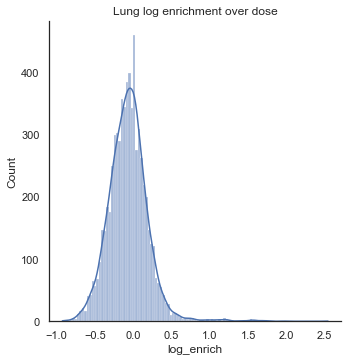

In [31]:
sns.displot(data=hellu_enrich_df, x="log_enrich", kde=True).set(title='Lung log enrichment over dose')


In [17]:
limit = 1
# Select column 'C' from the dataframe
column = hellu_enrich_df['log_enrich']
# Get count of values greater than 20 in the column 'C' 
count = column[column > limit].count()
count

39

In [40]:
hellu_enrich_df = hellu_enrich_df.sort_values(by='log_enrich')
hellu_enrich_top_x_df = hellu_enrich_df.tail(39)
hellu_enrich_top_x_df

count_i  count_f  \
MRDEDEKEAIKEALKRGNEAIAKFIAAAANVSPEEYERLRKEAE           20.0    206.0   
MGSGGNSGGSGRAEPRGTSKQAKNETTIKDIWYEQAVEYQNTTKAEV...      6.0     62.0   
MTDVQEFAIYCIRGLGYSEEEARRILKKANGNPRLADEIACRIG           10.0    105.0   
MSALYTADFKGDKGQRAPRSVKDIKLKAEEVQIALFEEKFESEA           32.0    352.0   
MPTEELEKRIEEARERGDRDEIERLLRKAGFSDAAAKLIAAALG           25.0    279.0   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN           20.0    243.0   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG            6.0     74.0   
MTLIRKVRSIYPFLGYSEEEARRILKKANGNPVLACEIAGRIG            47.0    585.0   
MSEEAKKALKIVRSIARSNNTEEKVERLARELVKKDQLKKVWQTYKD...      5.0     64.0   
MTHGQELAIGVIRVLGYSEEEARRILKKANGNPDLAREIALRIG           17.0    220.0   
MPMSRNVRSVHPLPGLLEEEARHILKKANGNPDLAREIAYRIG            30.0    435.0   
MTKLIRTKDTADTTGTETKDEENPDCNANPNVDPNAKKDRKCDD           15.0    220.0   
MTFLQEGAIVVIRRLGYSEEEARRILKKANGNPFLAVEIARIG            10.0    149.0   
MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR           18.0    270.0   
MNLIKVIDQLHVTKVVRSYAKREQINNATTGLTVVGAQSQT              38.0    578.0   
MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG            8.0    123.0   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS            9.0    139.0   
MQPEEWLSEAADALLKGDRDRARDALRQAGYSDEEAERDIRLVE           22.0    361.0   
MSEMFARLKDKFFLEIGDTEEARKALEKANYSPDEAEEIIRRHL           18.0    300.0   
MPDDLEKLARLALKWGVSEDTAREWLRNAGYDQSQAEEALKRAL           34.0    590.0   
MTLIRKVRSIYPFLGYSEEEAHRILKKANGNPVLACEIAGRIG             5.0    108.0   
MRTEDLKKEAKKLVKSGNPWAAALLLVANGYSSDEAEQIVRDIG           27.0    651.0   
MLKIVRTYEKLTSNRRPVQVEVSGENVEITTPTTLERVYKEVEDLES...      6.0    155.0   
MNLEEAVKRILEAILRGDKDKAEEIARRAGINPENWKLLLKAAL            5.0    136.0   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE           21.0    695.0   
MAKEVAVRLALAAIRFGDERFVQDAAQAANISPEELKKLARQVE           20.0    666.0   
MPKEAAKRVAEEAVKNGDEQAAWAALIFAGISPEEADKIIKELQ           26.0    869.0   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK           23.0    779.0   
MQTKPKGKIEPRIVNYKVEEKNPDCNANPNVDPNEENKINCKVS           13.0    460.0   
MDNEEAKKLAEEIVKLGSRKAVEEALRLAGVDEEEARRFIDKVE           15.0    543.0   
MPQEQYTLEAYQALQNGDKDRAREALRKAGASDKEIEDFIKVFG           24.0    900.0   
MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG           13.0    557.0   
MTFDQEFAIFGIRHLGYSEEEARRILKKANGNPHLAGEIAYRIG           12.0    564.0   
MNDAEAFFRAAELLRQGNEQEAQELLEKLGLSPQEAKEVLDDAK           11.0    522.0   
MDKIAAQAAATLAILAGNKEDARRILEEAGYSPEQAERIIRKAG           23.0   1184.0   
MTGYQERAIGVIRHLGYSEEEARRILKKANGNPRMAGEIAYRIG           33.0   1885.0   
MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV                   43.0   3771.0   
MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL           17.0   2700.0   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM            7.0   2323.0   

                                                        enrich  charge    hp  \
MRDEDEKEAIKEALKRGNEAIAKFIAAAANVSPEEYERLRKEAE         10.810939   -3.00 -44.4   
MGSGGNSGGSGRAEPRGTSKQAKNETTIKDIWYEQAVEYQNTTKAEV...   10.845926    1.00 -58.3   
MTDVQEFAIYCIRGLGYSEEEARRILKKANGNPRLADEIACRIG         11.020860    0.00 -15.8   
MSALYTADFKGDKGQRAPRSVKDIKLKAEEVQIALFEEKFESEA         11.545663   -1.00 -27.8   
MPTEELEKRIEEARERGDRDEIERLLRKAGFSDAAAKLIAAALG         11.713600   -2.00 -29.9   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN         12.752710   -4.00 -33.5   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG         12.945137   -2.00 -19.6   
MTLIRKVRSIYPFLGYSEEEARRILKKANGNPVLACEIAGRIG          13.064242    4.00  -4.4   
MSEEAKKALKIVRSIARSNNTEEKVERLARELVKKDQLKKVWQTYKD...   13.434953    6.25 -70.4   
MTHGQELAIGVIRVLGYSEEEARRILKKANGNPDLAREIALRIG         13.583133    1.25 -10.6   
MPMSRNVRSVHPLPGLLEEEARHILKKANGNPDLAREIAYRIG          15.219283    2.50 -23.3   
MTKLIRTKDTADTTGTETKDEENPDCNANPNVDPNAKKDRKCDD         15.394217   -3.00 -73.7   
MTFLQEGAIVVIRRLGYSEEEARRILKKANGNPFLAVEIARIG          15.639125    2.00   2.5   
MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR       

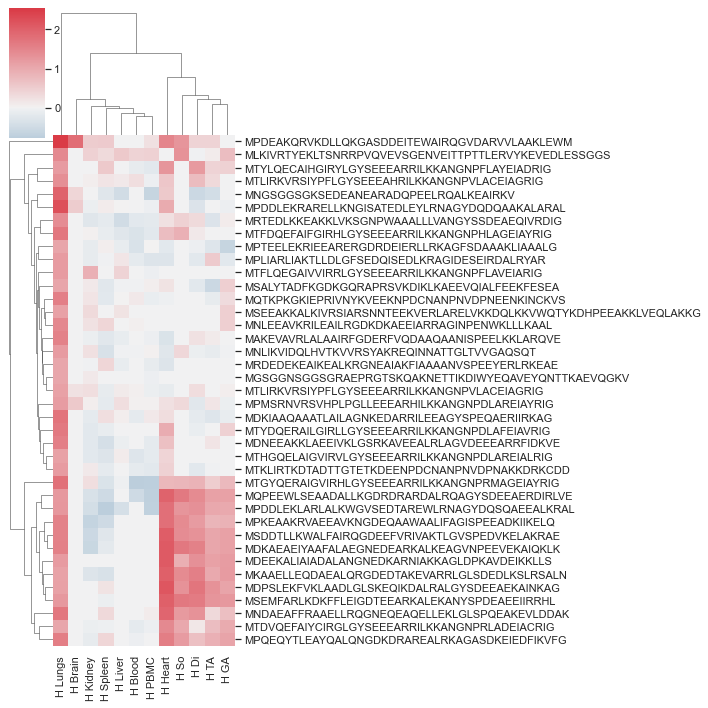

In [42]:
hellu_enrich_top_x_all_dict, hellu_enrich_top_x_all_df = add_all_organs_to_enrich_df(hellu_enrich_top_x_df)

healthy_mice_hellu_enrich_top_x_all_df = hellu_enrich_top_x_all_df[['H Brain', 'H Heart', 'H Kidney', 'H Liver', 'H Lungs', 'H Spleen', 'H TA', 'H GA', 'H So', 'H Di', 'H Blood', 'H PBMC']]

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_hellu_enrich_top_x_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

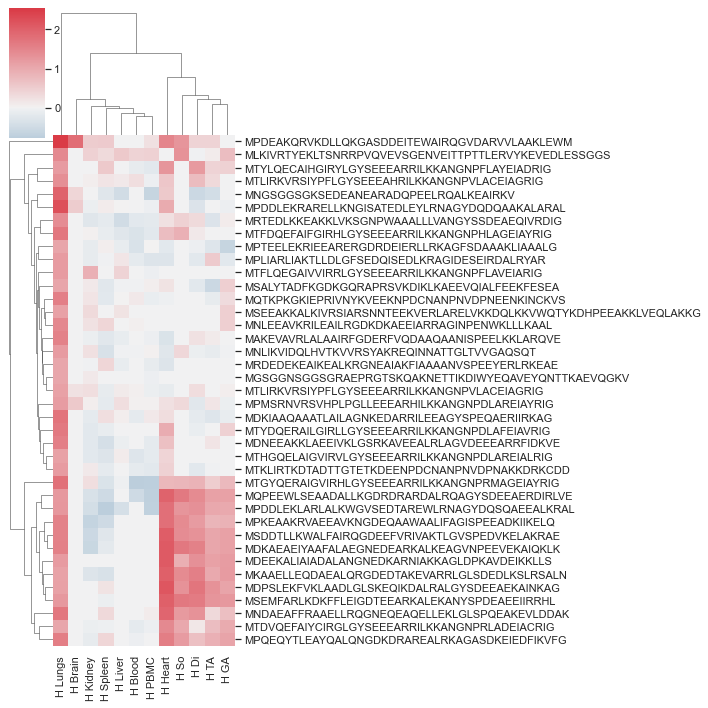

In [23]:
lung_clustermap = sns.clustermap(healthy_mice_hellu_enrich_top_x_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

lung_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_hellu_enrich_top_39_all_df_clustermap.png")


In [26]:
healthy_mice_hellu_enrich_top_x_all_df.index

Index(['MRDEDEKEAIKEALKRGNEAIAKFIAAAANVSPEEYERLRKEAE',
       'MGSGGNSGGSGRAEPRGTSKQAKNETTIKDIWYEQAVEYQNTTKAEVQGKV',
       'MTDVQEFAIYCIRGLGYSEEEARRILKKANGNPRLADEIACRIG',
       'MSALYTADFKGDKGQRAPRSVKDIKLKAEEVQIALFEEKFESEA',
       'MPTEELEKRIEEARERGDRDEIERLLRKAGFSDAAAKLIAAALG',
       'MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN',
       'MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG',
       'MTLIRKVRSIYPFLGYSEEEARRILKKANGNPVLACEIAGRIG',
       'MSEEAKKALKIVRSIARSNNTEEKVERLARELVKKDQLKKVWQTYKDHPEEAKKLVEQLAKKG',
       'MTHGQELAIGVIRVLGYSEEEARRILKKANGNPDLAREIALRIG',
       'MPMSRNVRSVHPLPGLLEEEARHILKKANGNPDLAREIAYRIG',
       'MTKLIRTKDTADTTGTETKDEENPDCNANPNVDPNAKKDRKCDD',
       'MTFLQEGAIVVIRRLGYSEEEARRILKKANGNPFLAVEIARIG',
       'MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR',
       'MNLIKVIDQLHVTKVVRSYAKREQINNATTGLTVVGAQSQT',
       'MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG',
       'MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS',
       'MQPEEWLSEAADALLKGDRDRARDALRQAGYSDEEAE

In [20]:
healthy_mice_hellu_enrich_top_x_all_df.loc['MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR']

H Brain     0.000000
H Heart    -0.286846
H Kidney   -0.140213
H Liver     0.178326
H Lungs     1.197117
H Spleen   -0.028552
H TA        0.552582
H GA       -0.214273
H So        0.000000
H Di       -0.206158
H Blood    -0.155636
H PBMC     -0.287506
Name: MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR, dtype: float64

In [ ]:
# Lung hits only heatmaps

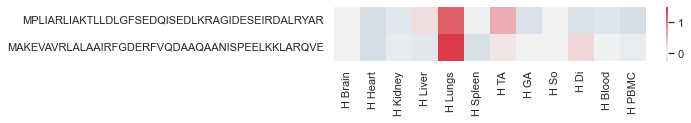

In [51]:
# get lung hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

lung_hits_df = pd.DataFrame()

lung_hits_df['MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR'] = healthy_mice_hellu_enrich_top_x_all_df.loc['MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR']
lung_hits_df['MAKEVAVRLALAAIRFGDERFVQDAAQAANISPEELKKLARQVE'] = healthy_mice_hellu_enrich_top_x_all_df.loc['MAKEVAVRLALAAIRFGDERFVQDAAQAANISPEELKKLARQVE']

lung_hits_df = lung_hits_df.T

plt.figure(figsize = (7,1))
    
lung_hits_fig = sns.heatmap(lung_hits_df,xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

lung_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/lung_hits.svg", bbox_inches="tight")
lung_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/lung_hits.png", bbox_inches="tight")


### Tumor vs dose

<AxesSubplot:xlabel='chip_lib', ylabel='enrich'>

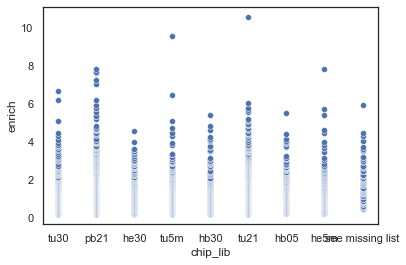

In [77]:
sns.scatterplot(data=tumtu_enrich_chip_df, x="chip_lib", y="enrich") #, hue="chip_lib")

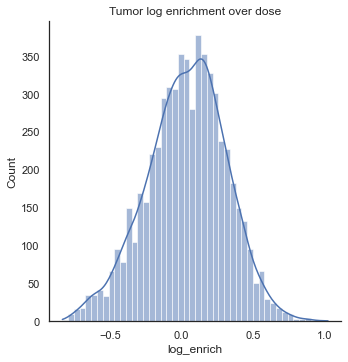

In [78]:
sns.displot(data=tumtu_enrich_df, x="log_enrich", kde=True).set(title='Tumor log enrichment over dose')


In [92]:
#sns.displot(data=tumtu_enrich_df, x="log_enrich", kde=True).set(title='Tumor log enrichment over dose')

limit = 0.7
# Select column 'C' from the dataframe
column = tumtu_enrich_df['log_enrich']
# Get count of values greater than 20 in the column 'C' 
count = column[column > limit].count()
count

35

In [93]:

tumtu_enrich_top_x_df = tumtu_enrich_chip_df.tail(35)
tumtu_enrich_top_x_df

enrich log_enrich  \
MTIKQDKPEITEYEPHNKNKKNPDCNANPNVDPNWLELDQCTKR         5.074812    0.70542   
MTDYQEFAIYYIRHLGYSEEEARRILKKANGNPGLALEIAGRIG         5.092494   0.706931   
MTYVQEHAIYYIRHLGYSEEEARRILKKANGNPRLADEIAYRIG         5.092494   0.706931   
MSTVDVNGKKYTCESVEWAKLACLIIALTYNLTCHVHGPTVTVK         5.124322   0.709636   
MPRVEDLIRAAQALKAGNEDKARELAKQAGLSDEEAEKFIQRAA         5.198588   0.715885   
MSTVDVNGKKYTYESPEWAKLACLIIALLYNLTCHVHGPTVTVK         5.198588   0.715885   
MPTEEDEMKASEADQKGNKEEAKEDDQKAGDSPEQAERDDAKAD         5.322364   0.726105   
MDKKDLEKSKRIEVYKTWKNFNPDCNANPNVDPNPIETKNCDKE         5.347119    0.72812   
MIREELEKEDREVVKKGDEDRAREILQRAGLSPEQVERIIREVLLES...   5.347119    0.72812   
MTGVQEFAIVHIRDLGYSEEEARRILKKANGNPLLAVEIAGRIG         5.394023   0.731913   
MTLFQECAICDIRHLGYSEEEARRILKKANGNPGLAYEIADRIG         5.410775   0.733259   
MCEIKEFTDPRKCEKYAADKGCQVEVDRDNQRCTVECC               5.484224   0.739115   
MAPLEPEYPGDNATPEQMHQYAHQLRRYINMLNGSGGNGSGGNGSGN...   5.569915   0.745849   
MPDESQDSNKKDNTTVETKIANPDCNANPNVDPNLKIRQKCWKD         5.569915   0.745849   
MGSKHHHRNLDRRHLVQTGDHHLRLQGYDVQYTKENGKCKIETG         5.662747   0.753027   
MTDDQEHAIDHIRCLGYSEEEARRILKKANGNPDLAREIAYRIG         5.729056   0.758083   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS...   5.755579   0.760089   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...   5.755579   0.760089   
MESMFAILKAKFFEEIDLAEGEEDRSLKKKLERGEASGARMARR         5.755579   0.760089   
MPSQADADRELSRVDAYQSPRNLGRAIVDALFEEENLERAQIAA         5.941243   0.773877   
MTDVYIFAKEREARRFEQEARDNGKDVQVYEVDGQFVVISN            5.941243   0.773877   
MQPMFEKLKVKFFCEIGDEEAARAAAEKAGLSEEERKEICKKNE         6.047337   0.781564   
MGRKVAGALAEEKALDTKTEQSDELEDPLEEVEIVLIPIEKADE         6.188795   0.791606   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG         6.196531   0.792149   
MSELRERAERLEKKAREGKIDPEFEAVWVSSQAGLYGDERLKEIADR...   6.461102   0.810307   
MTFFQEFAIRDIRHLGYSEEEARRILKKANGNPDLADEIACRIG         6.683899    0.82503   
MTKMDLSDLDLETLAPYIPMDGEDFELNPIEPLENGSGGNGSGGNGS...   7.055226   0.848511   
MQNNDALNPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKAG...    7.24089   0.859792   
MSTVDVNGKKYTYESPEWAKLACLIIALTANLTCHVHGPTVTVK         7.612218   0.881511   
MPVVIVVVVNDVVIVVKVSERIEVIVISSSGRKDTYHVP              7.638741   0.883022   
MCEEHVAALRLAASYKDQDRREEVKKCEKNCDEENQHRCAEKIRD        7.638741   0.883022   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF         7.797882   0.891977   
MQMFAALKANSFRIGETPDKACENLRAAGVDPEEAEKACRDAD          7.797882   0.891977   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE         9.580255   0.981377   
MSEQEAREAIKEAIKRGDEDWAELMAFIAGVDPTEVEKLKKEVG        10.582839   1.024602   

                                                   representation  \
MTIKQDKPEITEYEPHNKNKKNPDCNANPNVDPNWLELDQCTKR             0.000228   
MTDYQEFAIYYIRHLGYSEEEARRILKKANGNPGLALEIAGRIG             0.000178   
MTYVQEHAIYYIRHLGYSEEEARRILKKANGNPRLADEIAYRIG             0.000178   
MSTVDVNGKKYTCESVEWAKLACLIIALTYNLTCHVHGPTVTVK             0.000128   
MPRVEDLIRAAQALKAGNEDKARELAKQAGLSDEEAEKFIQRAA             0.000156   
MSTVDVNGKKYTYESPEWAKLACLIIALLYNLTCHVHGPTVTVK             0.000156   
MPTEEDEMKASEADQKGNKEEAKEDDQKAGDSPEQAERDDAKAD              0.00024   
MDKKDLEKSKRIEVYKTWKNFNPDCNANPNVDPNPIETKNCDKE             0.000134   
MIREELEKEDREVVKKGDEDRAREILQRAGLSPEQVERIIREVLLES...       0.000134   
MTGVQEFAIVHIRDLGYSEEEARRILKKANGNPLLAVEIAGRIG             0.000513   
MTLFQECAICDIRHLGYSEEEARRILKKANGNPGLAYEIADRIG             0.000189   
MCEIKEFTDPRKCEKYAADKGCQVEVDRDNQRCTVECC                   0.000357   
MAPLEPEYPGDNATPEQMHQYAHQLRRYINMLNGSGGNGSGGNGSGN...       0.000167   
MPDESQDSNKKDNTTVETKIANPDCNANPNVDPNLKIRQKCWKD             0.000362   
MGSKHHHRNLDRRHLVQTGDHHLRLQGYDVQYTKENGKCKIETG              0.00034   
MTDDQEHAIDHIRCLGYSEEEARRILKKANGNPDLAREIAYRIG             0.000401   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS...       0.000518   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...       0.000173   
MESMFAI

In [94]:
tumtu_enrich_top_x_all_dict, tumtu_enrich_top_x_all_df = add_all_organs_to_enrich_df(tumtu_enrich_top_x_df)

In [95]:
tumor_mice_tumtu_enrich_top_x_all_df = tumtu_enrich_top_x_all_df[['T Brain', 'T Heart', 'T Kidney', 'T Liver', 'T Lungs', 'T Spleen', 'T Tumor', 'T TA', 'T GA', 'T So', 'T Di', 'T Blood', 'H PBMC']]

In [83]:
tumor_mice_tumtu_enrich_top_x_all_df.loc['MPREWQNPDCNANPNVDPNEDLIKDCTTKDLHTDQIKEQLEKEI']

T Brain     0.000000
T Heart     0.000000
T Kidney   -0.025307
T Liver    -0.264641
T Lungs    -0.139392
T Spleen   -0.090836
T Tumor     0.459059
T TA       -0.066634
T GA        0.000000
T So        0.000000
T Di       -0.060641
T Blood     0.221528
H PBMC      0.077641
Name: MPREWQNPDCNANPNVDPNEDLIKDCTTKDLHTDQIKEQLEKEI, dtype: float64

In [84]:
tumor_mice_tumtu_enrich_top_x_all_df.loc['MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG']

T Brain     0.299994
T Heart    -0.009173
T Kidney   -0.150246
T Liver    -0.134307
T Lungs    -0.030247
T Spleen    0.085255
T Tumor     0.792149
T TA        0.000000
T GA        0.046388
T So        0.000000
T Di        0.182397
T Blood    -0.204441
H PBMC      0.064676
Name: MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG, dtype: float64

In [ ]:
hit_list_1 = tumor_mice_tumtu_enrich_top_x_all_df.loc['MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG'].values.flatten().tolist()

In [72]:
tumor_mice_tumtu_enrich_top_x_all_df.loc['MQNNDALNPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKAGSSGS']

T Brain     0.000000
T Heart    -0.244265
T Kidney   -0.345954
T Liver     0.042967
T Lungs    -0.292791
T Spleen    0.483990
T Tumor     1.979744
T TA        0.000000
T GA        0.000000
T So        0.000000
T Di        0.000000
T Blood     0.199931
H PBMC      0.663378
Name: MQNNDALNPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKAGSSGS, dtype: float64

In [149]:
tumor_mice_tumtu_enrich_top_x_all_df.loc['MTCDQEFAIFCIRFLGYSEEEARRILKKANGNPRLALEIAFRIG']

T Brain     0.000000
T Heart     0.000000
T Kidney    0.000000
T Liver     0.000000
T Lungs     0.000000
T Spleen    0.000000
T Tumor     1.331717
T TA        0.000000
T GA        0.000000
T So        0.000000
T Di        0.000000
T Blood     0.000000
H PBMC      0.000000
Name: MTCDQEFAIFCIRFLGYSEEEARRILKKANGNPRLALEIAFRIG, dtype: float64

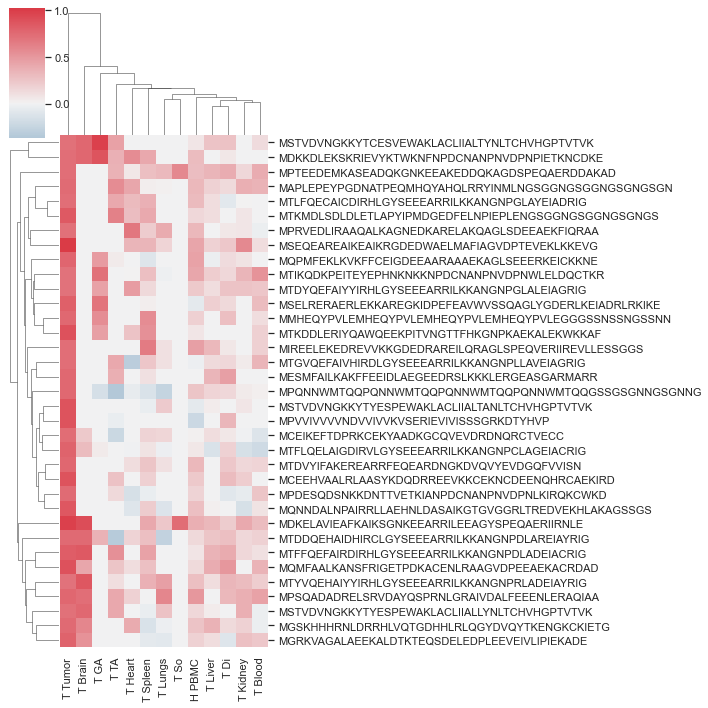

In [96]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [86]:
tumor_mice_tumtu_enrich_top_x_all_df_sp = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Spleen")
tumor_mice_tumtu_enrich_top_x_all_df_sp = tumor_mice_tumtu_enrich_top_x_all_df_sp.head(40)
tumor_mice_tumtu_enrich_top_x_all_df_sp

T Brain   T Heart  \
MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG       -0.032070 -0.027656   
MGGCPDPNANPNVDPAKDEDQQTKAYKACTE                     0.436751 -0.039136   
MNEKAERIAKQLQKNGVTPDEIERVDKELGANPEEVRQIVERLK        0.000000  0.000000   
MKNDEIGKKANEAVKKGDLDKAAELASRASGYDATANPNVQSVG        0.000000 -0.226657   
MGGNGSSGGSSTQTYKFTDEQAAKEFAEKAKKKGLDATVTKENGTWK...  0.000000  0.000000   
MTDDQEHAIRGIRFLGYSEEEARRILKKANGNPCLAGEIAGRIG        0.432923  0.000000   
MTGYQEHAIRCIRHLGYSEEEARRILKKANGNRIG                 0.551022  0.000000   
MVELDECEANITPKVEVPDPNANPNVDPNKEPRICREKLNGK          0.204444  0.128731   
MTGGQECAIGYIRYLGYSEEEARRILKKANGNPVLACEIAGRIG        0.235536  0.000000   
MEELAADSKAPEDGDDVALKRRAIAEEAERAIANALSGTAKEFK        0.546866 -0.185264   
MPTSSNPDCNANPNVDPNTDELRKCLTKNKVPEKDVDTEIKKLQ        0.000000  0.000000   
MGNGSEKLTAAWKVAKTKKNIQLQGLDWNAKKPEFLNVVETVIENV      0.000000  0.273374   
MTGRQELAISVIRHLGYSEEEARRILKKANGNPHLACEIALRIG        0.439656  0.077977   
MTGVTNIVNLIAVFVVRSYMKRLVAVVLYTIEETVKQQGIR           0.000000  0.000000   
MATRTKATLDATLKKRLDAAKNPDCNANPNVDPNAKKDIKCSDD        0.429897  0.000000   
MSSTTTNPDCNANPNVDPNEDYIRKCQETNPPEEEIEDRLRKII        0.000000  0.115766   
MAPKSKAYAQLVDKRELKNRSTAIATEAEGASEDEGAALLLRLI        0.000000 -0.118317   
MCSFVCNGEICSVWSAKGGYQTRGSCDECEEFARRMCG              0.000000  0.212676   
MMADEEKLPPGWEKRMSRSSGRVYYFNHIANASQWERPSGGSSGSNG...  0.000000  0.000000   
MKGTKLKQIILGRSLIDEELENTARKSLEPERELIVNSAKAALS        0.266656 -0.217449   
MTFGQEYAILHIRGLGYSEEEARRILKKANGNPLLALEIAGRIG        0.077929 -0.400864   
MMADEEKLPPGWEKRMSRSSGRVYYFNHITNASQEERPSGSNGGSNG     0.622587  0.298697   
MSGGNGSGPEDLKREAEKLWRNGVSKEEIKKWLKKAGASEDEIREIE...  0.369075  0.000000   
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG        0.000000 -0.259898   
MPTDIGKLERKLEIAQTKKIENPDCNANPNVDPNKEQKYQCPEN        0.000000 -0.147475   
MQPMCAELKAKFFLEIGDRDAARNALRKAGYSDEEAERIIRKYE        0.633792  0.000000   
MSDELERLCRRGERTYLINHALNAARLNNPKVAKIAEKC            -0.269073 -0.838477   
MRAVSLAQRAEEAAANGDKDRAREAARRAGLSDKLIEDLVKTAA       -0.240830 -0.166781   
MTYVQEVAIGGIRDLGYSEEEARRILKKANGNPLLACEIAHRIG        0.000000  0.084732   
MGNGSGSGGSSQETRTYTDRRRAEEFRERAERNGQKVEVRVDNGRVE...  0.000000  0.000000   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS...  0.000000 -0.060325   
MGSKHHHRNLDRRHLVQTGDHHLRLQGYDVQYTKENGKCKIETG        0.596004  0.398313   
MDKDSVEAAIELLLAAGDEDSAREAAKEAGLTEEDLRRLKKRVS        0.125263  0.000000   
MSELRERAERLEKKAREGKIDPEFEAVNVSSLKIKE               -0.027364 -0.415713   
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG        0.307031 -0.259898   
MFALLNFQAKATSLLERPSKQILAEKSAGDEAKAWEALKIGSNK        0.085182  0.067461   
MTFCQEGAIRDIRFLGYYEEEARRILKKANGNPGLADEIAVRIG        0.000000  0.212676   
MDKHDQETETEAIREPELSRTNPDCNANPNVDPNNDDKKACARR        0.000000  0.227740   
MNGSMRNKVQGFPNQNNNKFEGKPQPSADYASKRADGTTNTQPQERM...  0.659016  0.474788   
MQPMFEKLKVKFFCEIGDEEAARAAAEKAGLSEEERKEICKKNE        0.000000  0.000000   

                                                    T Kidney   T Liver  \
MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG       -0.576215 -0.027852   
MGGCPDPNANPNVDPAKDEDQQTKAYKACTE                    -0.247156 -0.171219   
MNEKAERIAKQLQKNGVTPDEIERVDKELGANPEEVRQIVERLK        0.076150 -0.163183   
MKNDEIGKKANEAVKKGDLDKAAELASRASGYDATANPNVQSVG       -0.045511  0.074178   
MGGNGSSGGSSTQTYKFTDEQAAKEFAEKAKKKGLDATVTKENGTWK... -0.118061 -0.095283   
MTDDQEHAIRGIRFLGYSEEEARRILKKANGNPCLAGEIAGRIG       -0.008917  0.256900   
MTGYQEHAIRCIRHLGYSEEEARRILKKANGNRIG                 0.000000 -0.299403   
MVELDECEANITPKVEVPDPNANPNVDPNKEPRICREKLNGK          0.079428  0.153359   
MTGGQECAIGYIRYLGYSEEEARRILKKANGNPVLACEIAGRIG        0.150784  0.057578   
MEELAADSKAPEDGDDVALKRRAIAEEAERAIANALSGTAKEFK        0.229965  0.000000   
MPTSSNPDCNANPNVDPNTDELRKCLTKNKVPEKDVDTEIKKLQ       -0.004118 -0.185460   
MGNGSEKLTAAWKVAKTKKNIQLQGLDWNAKKPEFLNVVETVIENV      0.060607 -0.243452   
MTGRQELAISVIRHLGYSEEEARRILKKANGNPHLACEIALRIG        0.24

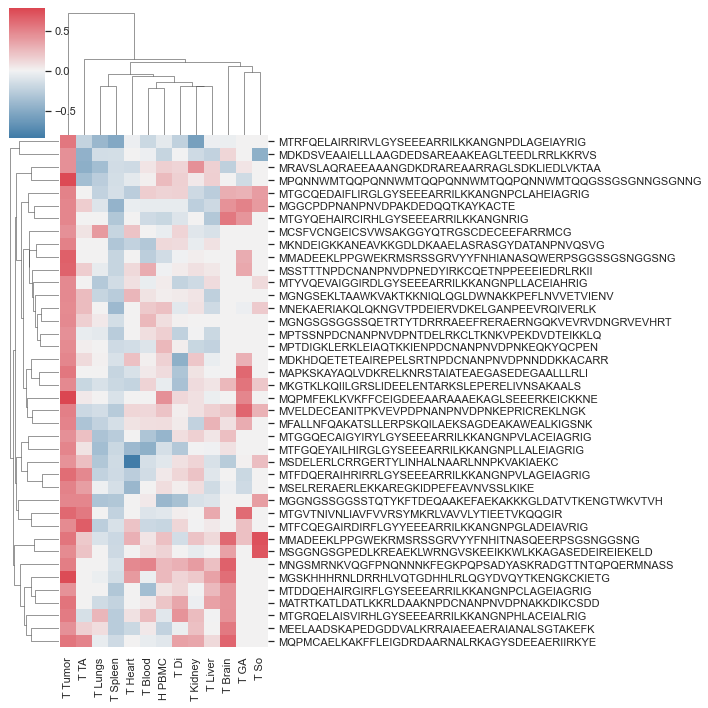

In [87]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_sp, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [88]:
tumor_mice_tumtu_enrich_top_x_all_df_br = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Brain")
tumor_mice_tumtu_enrich_top_x_all_df_br = tumor_mice_tumtu_enrich_top_x_all_df_br.tail(100)
tumor_mice_tumtu_enrich_top_x_all_df_br

T Brain   T Heart  \
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG        0.307031 -0.259898   
MSTVDVNGKKYTYVSPEWAKLACLIIALTYNLTCHVHGPTVTVK        0.307984 -0.220026   
MTGFQEYAIFDIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG        0.312078  0.204707   
MTKHIRTTDATEAVKIAADAERRGLRYEIRVENGELEIRID           0.316418 -0.637562   
MDQKELQKQVKEAVKNGDEDRVKELLKRVGYSDEQVERIKDKLSLES...  0.317923  0.161523   
...                                                      ...       ...   
MPEDAILIAAKLDKNGKSTEQIKKELKKLGVSEIEARFIEALAL        0.944806  0.240705   
MNQTKKKTLIEQEPSDKKLIENPDCNANPNVDPNSYEKRNCTEE        1.006552  0.064613   
MTNEIDKKKPEDYTAKETERSDNPDCNANPNVDPNKDKKEKCAI        1.047877  0.048819   
MDVDTTIKRVEEVARRGEPITFGNYTDHSEEVVKEVKTKLKRNSLES...  1.062906  0.000000   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM        1.115697  1.516181   

                                                    T Kidney   T Liver  \
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG       -0.173727 -0.260093   
MSTVDVNGKKYTYVSPEWAKLACLIIALTYNLTCHVHGPTVTVK        0.116022 -0.220222   
MTGFQEYAIFDIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG        0.087115  0.095367   
MTKHIRTTDATEAVKIAADAERRGLRYEIRVENGELEIRID           0.137819  0.115570   
MDQKELQKQVKEAVKNGDEDRVKELLKRVGYSDEQVERIKDKLSLES...  0.150784  0.000000   
...                                                      ...       ...   
MPEDAILIAAKLDKNGKSTEQIKKELKKLGVSEIEARFIEALAL        0.071603  0.000000   
MNQTKKKTLIEQEPSDKKLIENPDCNANPNVDPNSYEKRNCTEE        0.475295  0.483547   
MTNEIDKKKPEDYTAKETERSDNPDCNANPNVDPNKDKKEKCAI        0.000000  0.384416   
MDVDTTIKRVEEVARRGEPITFGNYTDHSEEVVKEVKTKLKRNSLES...  0.071603  0.115570   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM        0.384867  0.270472   

                                                     T Lungs  T Spleen  \
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG       -0.229820 -0.130707   
MSTVDVNGKKYTYVSPEWAKLACLIIALTYNLTCHVHGPTVTVK       -0.174154 -0.038448   
MTGFQEYAIFDIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG       -0.247731  0.089620   
MTKHIRTTDATEAVKIAADAERRGLRYEIRVENGELEIRID          -0.290660 -0.050218   
MDQKELQKQVKEAVKNGDEDRVKELLKRVGYSDEQVERIKDKLSLES...  0.000000  0.283980   
...                                                      ...       ...   
MPEDAILIAAKLDKNGKSTEQIKKELKKLGVSEIEARFIEALAL        0.000000  0.034103   
MNQTKKKTLIEQEPSDKKLIENPDCNANPNVDPNSYEKRNCTEE       -0.160581  0.527018   
MTNEIDKKKPEDYTAKETERSDNPDCNANPNVDPNKDKKEKCAI        0.000000  0.230398   
MDVDTTIKRVEEVARRGEPITFGNYTDHSEEVVKEVKTKLKRNSLES...  0.000000  0.000000   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM        2.706869  0.531428   

                                                     T Tumor      T TA  \
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG        0.508488  0.000000   
MSTVDVNGKKYTYVSPEWAKLACLIIALTYNLTCHVHGPTVTVK        0.524000  0.500664   
MTGFQEYAIFDIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG        0.628735 -0.002517   
MTKHIRTTDATEAVKIAADAERRGLRYEIRVENGELEIRID           0.506626  0.231191   
MDQKELQKQVKEAVKNGDEDRVKELLKRVGYSDEQVERIKDKLSLES...  0.435059  0.000000   
...                                                      ...       ...   
MPEDAILIAAKLDKNGKSTEQIKKELKKLGVSEIEARFIEALAL        0.648939  0.000000   
MNQTKKKTLIEQEPSDKKLIENPDCNANPNVDPNSYEKRNCTEE        0.539794  0.196607   
MTNEIDKKKPEDYTAKETERSDNPDCNANPNVDPNKDKKEKCAI        0.544203  0.000000   
MDVDTTIKRVEEVARRGEPITFGNYTDHSEEVVKEVKTKLKRNSLES...  0.569757  0.372699   
MPDEAKQRVKDLLQKGASDDEITEWAIRQGVDARVVLAAKLEWM        0.457053  0.494808   

                                                        T GA      T So  \
MTGCQEDAIFLIRGLGYSEEEARRILKKANGNPCLAHEIAGRIG        0.293974  0.384951   
MSTVDVNGKKYTYVSPEWAKLACLIIALTYNLTCHVHGPTVTVK        0.090807  0.486709   
MTGFQEYAIFDIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG       -0.012733  0.000000   
MTKHIRTTDATEAVKIAADAERRGLRYEIRVENGELEIRID          -0.280971  0.000000   
MDQKELQKQVKEAVKNGDEDRVKELLKRVGYSDEQVERIKDKLSLES...  0.000000  0.000000   
...                                                  

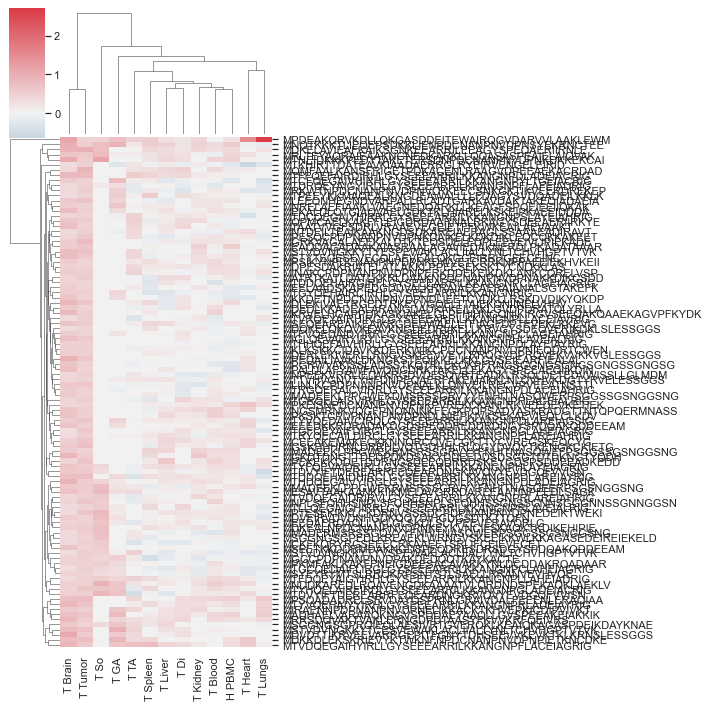

In [89]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_br, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

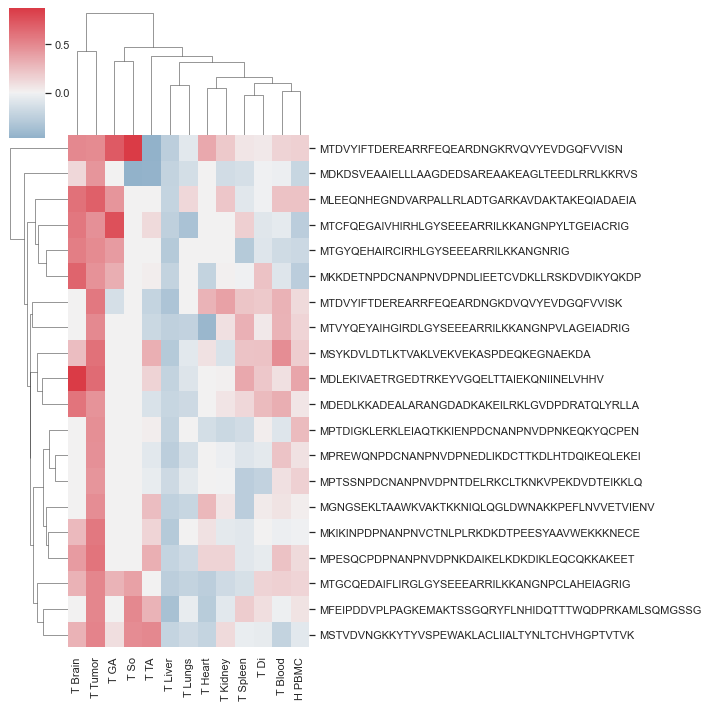

In [90]:
tumor_mice_tumtu_enrich_top_x_all_df_br_li = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Liver").head(20)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_br_li, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

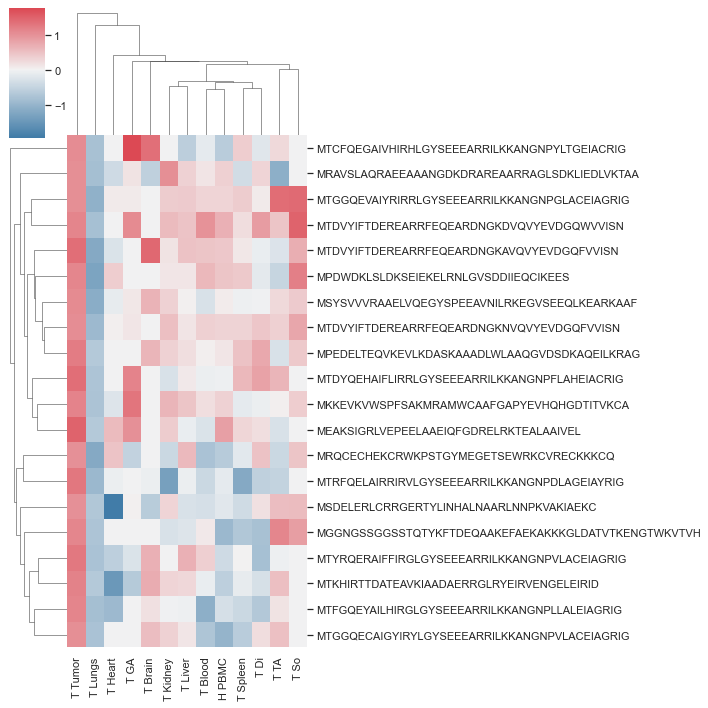

In [37]:
tumor_mice_tumtu_enrich_top_x_all_df_lu = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Lungs")
tumor_mice_tumtu_enrich_top_x_all_df_lu = tumor_mice_tumtu_enrich_top_x_all_df_lu.head(20)
tumor_mice_tumtu_enrich_top_x_all_df_lu
sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_lu, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [199]:
tumor_mice_tumtu_enrich_top_x_all_df = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by = "T Tumor")
tumor_mice_tumtu_enrich_top_x_all_df_top_y = tumor_mice_tumtu_enrich_top_x_all_df.tail(20)
tumor_mice_tumtu_enrich_top_x_all_df_top_y

T Brain   T Heart  \
MTDDQEHAIDHIRCLGYSEEEARRILKKANGNPDLAREIAYRIG        1.733665  0.400092   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.000000  0.000000   
MESMFAILKAKFFEEIDLAEGEEDRSLKKKLERGEASGARMARR        0.000000  0.000000   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS...  0.000000 -0.138904   
MPSQADADRELSRVDAYQSPRNLGRAIVDALFEEENLERAQIAA        1.671592  0.420712   
MTDVYIFAKEREARRFEQEARDNGKDVQVYEVDGQFVVISN           0.000000  0.266561   
MQPMFEKLKVKFFCEIGDEEAARAAAEKAGLSEEERKEICKKNE        0.000000  0.000000   
MGRKVAGALAEEKALDTKTEQSDELEDPLEEVEIVLIPIEKADE        1.231036  0.000000   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG        0.690763 -0.021121   
MSELRERAERLEKKAREGKIDPEFEAVWVSSQAGLYGDERLKEIADR...  0.000000  0.000000   
MTFFQEFAIRDIRHLGYSEEEARRILKKANGNPDLADEIACRIG        1.956808  0.000000   
MTKMDLSDLDLETLAPYIPMDGEDFELNPIEPLENGSGGNGSGGNGS...  0.000000  0.672026   
MQNNDALNPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKAG...  0.000000 -0.244265   
MSTVDVNGKKYTYESPEWAKLACLIIALTANLTCHVHGPTVTVK        0.000000  0.000000   
MPVVIVVVVNDVVIVVKVSERIEVIVISSSGRKDTYHVP             0.000000  0.000000   
MCEEHVAALRLAASYKDQDRREEVKKCEKNCDEENQHRCAEKIRD       0.000000  0.000000   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.000000  0.603033   
MQMFAALKANSFRIGETPDKACENLRAAGVDPEEAEKACRDAD         0.961053  0.266561   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        2.097536  0.000000   
MSEQEAREAIKEAIKRGDEDWAELMAFIAGVDPTEVEKLKKEVG        0.000000  0.777387   

                                                    T Kidney   T Liver  \
MTDDQEHAIDHIRCLGYSEEEARRILKKANGNPDLAREIAYRIG        0.347193  0.571492   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.000000  0.000000   
MESMFAILKAKFFEEIDLAEGEEDRSLKKKLERGEASGARMARR        0.000000  0.776936   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS...  0.095879  0.371471   
MPSQADADRELSRVDAYQSPRNLGRAIVDALFEEENLERAQIAA        0.858019  0.000000   
MTDVYIFAKEREARRFEQEARDNGKDVQVYEVDGQFVVISN           0.347193  0.000000   
MQPMFEKLKVKFFCEIGDEEAARAAAEKAGLSEEERKEICKKNE        0.193043 -0.070362   
MGRKVAGALAEEKALDTKTEQSDELEDPLEEVEIVLIPIEKADE        0.634875  0.266111   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG       -0.345954 -0.309254   
MSELRERAERLEKKAREGKIDPEFEAVWVSSQAGLYGDERLKEIADR...  0.000000  0.448432   
MTFFQEFAIRDIRHLGYSEEEARRILKKANGNPDLADEIACRIG        0.347193  0.805107   
MTKMDLSDLDLETLAPYIPMDGEDFELNPIEPLENGSGGNGSGGNGS...  0.164872  0.266111   
MQNNDALNPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKAG... -0.345954  0.042967   
MSTVDVNGKKYTYESPEWAKLACLIIALTANLTCHVHGPTVTVK        0.164872  0.083789   
MPVVIVVVVNDVVIVVKVSERIEVIVISSSGRKDTYHVP             0.000000  0.000000   
MCEEHVAALRLAASYKDQDRREEVKKCEKNCDEENQHRCAEKIRD       0.480725  0.000000   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.000000  0.000000   
MQMFAALKANSFRIGETPDKACENLRAAGVDPEEAEKACRDAD         0.000000  0.894719   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        0.934980  0.736114   
MSEQEAREAIKEAIKRGDEDWAELMAFIAGVDPTEVEKLKKEVG        1.328022  0.420261   

                                                     T Lungs  T Spleen  \
MTDDQEHAIDHIRCLGYSEEEARRILKKANGNPDLAREIAYRIG       -0.629263  0.658343   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.000000  1.282498   
MESMFAILKAKFFEEIDLAEGEEDRSLKKKLERGEASGARMARR        0.000000  0.232676   
MPQNNWMTQQPQNNWMTQQPQNNWMTQQPQNNWMTQQGSSGSGNNGS... -0.592895 -0.326940   
MPSQADADRELSRVDAYQSPRNLGRAIVDALFEEENLERAQIAA        1.370714  0.000000   
MTDVYIFAKEREARRFEQEARDNGKDVQVYEVDGQFVVISN           0.218035  0.589351   
MQPMFEKLKVKFFCEIGDEEAARAAAEKAGLSEEERKEICKKNE        0.000000 -0.257947   
MGRKVAGALAEEKALDTKTEQSDELEDPLEEVEIVLIPIEKADE       -0.187430 -0.172789   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG       -0.069647  0.196308   
MSELRERAERLEKKAREGKIDPEFEAVWVSSQAGLYGDERLKEIADR...  0.000000  0.078525   
MTFFQEFAIRDIRHLGYSEEEARRILKKANGNPDLADEIACRIG        0.000000  1.022987   
MTKMDLSDLDLETLAPYIPMDGEDFELNPIEPLENGSGGNGSGGNGS...  0.0

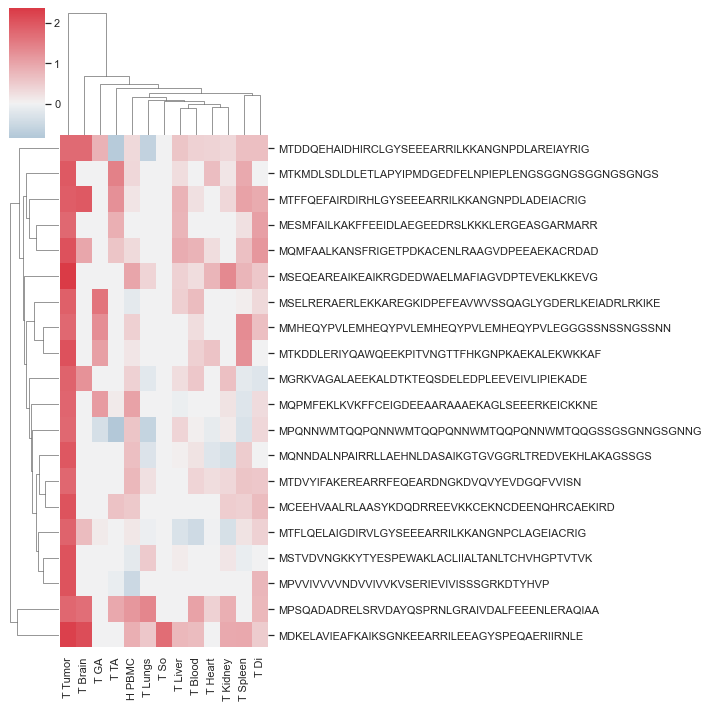

In [200]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_top_y, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [48]:
tumor_mice_tumtu_enrich_top_hundred_all_df = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Tumor").tail(100)

In [49]:
tumor_mice_tumtu_enrich_top_hundred_all_df_liver_sort = tumor_mice_tumtu_enrich_top_hundred_all_df.sort_values(by="T Liver")

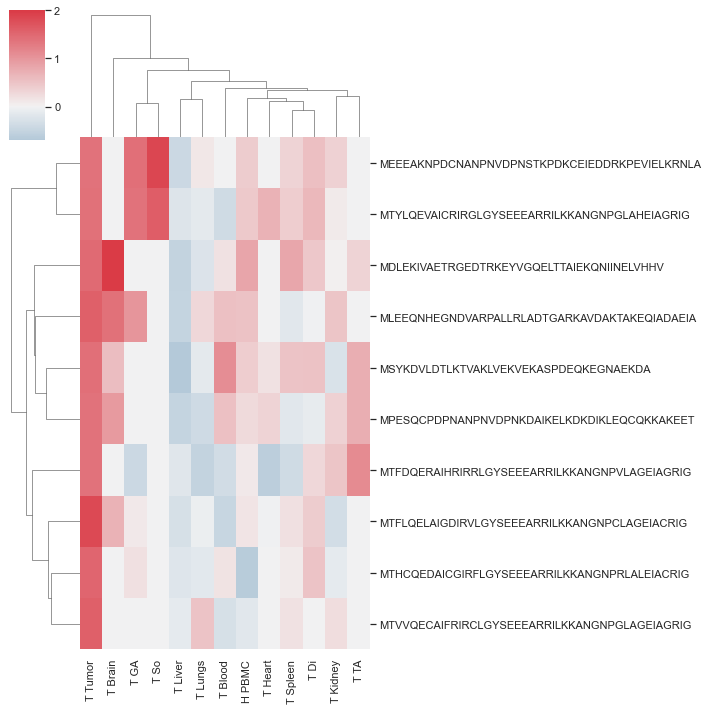

In [50]:
tumor_mice_tumtu_enrich_top_hundred_all_df_liver_sort_bottom_x = tumor_mice_tumtu_enrich_top_hundred_all_df_liver_sort.head(10)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_hundred_all_df_liver_sort_bottom_x, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

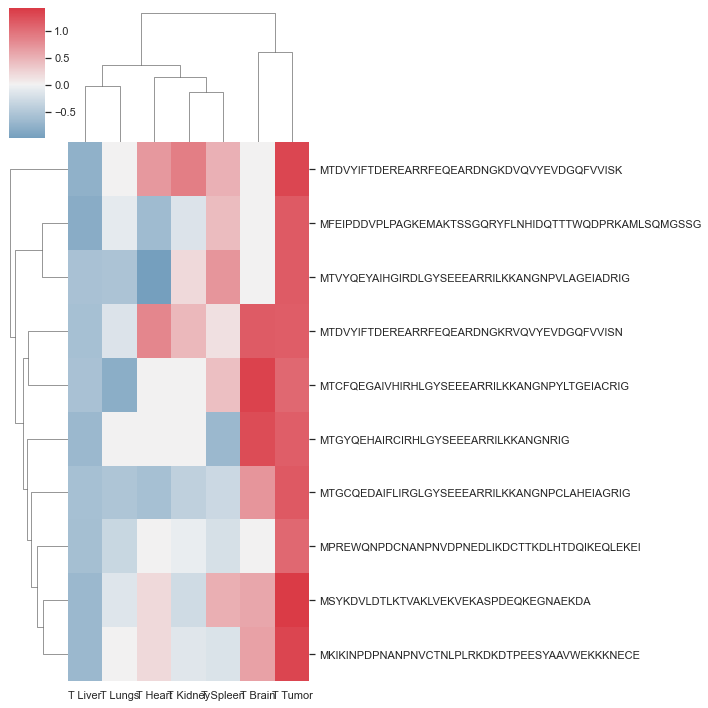

In [52]:
tumor_mice_tumtu_enrich_top_x_all_df_liver_sort_bottom_x = tumor_mice_tumtu_enrich_top_x_all_df_liver_sort_bottom_x[['T Brain', 'T Heart', 'T Kidney', 'T Liver', 'T Lungs', 'T Spleen', 'T Tumor']]
sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_liver_sort_bottom_x, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [142]:
tumor_mice_tumtu_enrich_top_x_all_df_liver_sort_bottom_x

T Brain   T Heart  T Kidney  \
MSYKDVLDTLKTVAKLVEKVEKASPDEQKEGNAEKDA         0.575629  0.186518 -0.271846   
MDLEKIVAETRGEDTRKEYVGQELTTAIEKQNIINELVHHV     2.002226  0.000000  0.028739   
MLEEQNHEGNDVARPALLRLADTGARKAVDAKTAKEQIADAEIA  1.402307  0.000000  0.490294   
MPESQCPDPNANPNVDPNKDAIKELKDKDIKLEQCQKKAKEET   0.965094  0.340669  0.347193   
MEEEAKNPDCNANPNVDPNSTKPDKCEIEDDRKPEVIELKRNLA  0.000000  0.000000  0.347193   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG  0.690763 -0.021121 -0.345954   
MTYLQEVAICRIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG  0.000000  0.697344  0.084829   
MTHCQEDAICGIRFLGYSEEEARRILKKANGNPRLALEIACRIG  0.000000  0.000000 -0.122810   
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG  0.000000 -0.598436  0.493797   
MTVVQECAIFRIRCLGYSEEEARRILKKANGNPGLAGEIAGRIG  0.000000  0.000000  0.229410   

                                               T Liver   T Lungs  T Spleen  \
MSYKDVLDTLKTVAKLVEKVEKASPDEQKEGNAEKDA        -0.689401 -0.149690  0.509308   
MDLEKIVAETRGEDTRKEYVGQELTTAIEKQNIINELVHHV    -0.522347 -0.233950  0.816124   
MLEEQNHEGNDVARPALLRLADTGARKAVDAKTAKEQIADAEIA -0.507079  0.292143 -0.183839   
MPESQCPDPNANPNVDPNKDAIKELKDKDIKLEQCQKKAKEET  -0.507079 -0.401004 -0.183839   
MEEEAKNPDCNANPNVDPNSTKPDKCEIEDDRKPEVIELKRNLA -0.427037  0.112674  0.340889   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG -0.309254 -0.069647  0.196308   
MTYLQEVAICRIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG -0.219397 -0.149690  0.403947   
MTHCQEDAICGIRFLGYSEEEARRILKKANGNPRLALEIACRIG -0.203893 -0.156659  0.078525   
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG -0.193422 -0.529180 -0.381007   
MTVVQECAIFRIRCLGYSEEEARRILKKANGNPGLAGEIAGRIG -0.139355  0.505717  0.183886   

                                               T Tumor      T TA      T GA  \
MSYKDVLDTLKTVAKLVEKVEKASPDEQKEGNAEKDA         1.414194  0.731607  0.000000   
MDLEKIVAETRGEDTRKEYVGQELTTAIEKQNIINELVHHV     1.471247  0.339046  0.000000   
MLEEQNHEGNDVARPALLRLADTGARKAVDAKTAKEQIADAEIA  1.586044  0.000000  1.007599   
MPESQCPDPNANPNVDPNKDAIKELKDKDIKLEQCQKKAKEET   1.371634  0.731607  0.000000   
MEEEAKNPDCNANPNVDPNSTKPDKCEIEDDRKPEVIELKRNLA  1.388876  0.000000  1.409725   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG  1.823990  0.000000  0.106813   
MTYLQEVAICRIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG  1.393140  0.000000  1.379163   
MTHCQEDAICGIRFLGYSEEEARRILKKANGNPRLALEIACRIG  1.525008  0.000000  0.202123   
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG  1.383011  1.114258 -0.421713   
MTVVQECAIFRIRCLGYSEEEARRILKKANGNPGLAGEIAGRIG  1.574279  0.000000  0.000000   

                                                  T So      T Di   T Blood  \
MSYKDVLDTLKTVAKLVEKVEKASPDEQKEGNAEKDA         0.000000  0.527540  1.095020   
MDLEKIVAETRGEDTRKEYVGQELTTAIEKQNIINELVHHV     0.000000  0.458205  0.191632   
MLEEQNHEGNDVARPALLRLADTGARKAVDAKTAKEQIADAEIA  0.000000 -0.019004  0.535404   
MPESQCPDPNANPNVDPNKDAIKELKDKDIKLEQCQKKAKEET   0.000000 -0.114314  0.535404   
MEEEAKNPDCNANPNVDPNSTKPDKCEIEDDRKPEVIELKRNLA  1.868561  0.553516 -0.000739   
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG  0.000000  0.419984 -0.470743   
MTYLQEVAICRIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG  1.606197  0.627624 -0.380887   
MTHCQEDAICGIRFLGYSEEEARRILKKANGNPRLALEIACRIG  0.000000  0.510956  0.165246   
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG  0.000000  0.294654 -0.354911   
MTVVQECAIFRIRCLGYSEEEARRILKKANGNPGLAGEIAGRIG  0.000000  0.000000 -0.300844   

                                                H PBMC  
MSYKDVLDTLKTVAKLVEKVEKASPDEQKEGNAEKDA         0.401014  
MDLEKIVAETRGEDTRKEYVGQELTTAIEKQNIINELVHHV     0.833771  
MLEEQNHEGNDVARPALLRLADTGARKAVDAKTAKEQIADAEIA  0.523616  
MPESQCPDPNANPNVDPNKDAIKELKDKDIKLEQCQKKAKEET   0.261252  
MEEEAKNPDCNANPNVDPNSTKPDKCEIEDDRKPEVIELKRNLA  0.418256  
MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG  0.148923  
MTYLQEVAICRIRGLGYSEEEARRILKKANGNPGLAHEIAGRIG  0.443574  
MTHCQEDAICGIRFLGYSEEEARRILKKANGNPRLALEIACRIG -0.639534  
MTFDQERAIHRIRRLGYSEEEARRILKKANGNPVLAGEIAGRIG  0.104906  
MTVVQECAIFRIRCLGYSEEEARRILKKANGNPGLAGEIAG

In [ ]:
# MTFLQELAIGDIRVLGYSEEEARRILKKANGNPCLAGEIACRIG is interesting

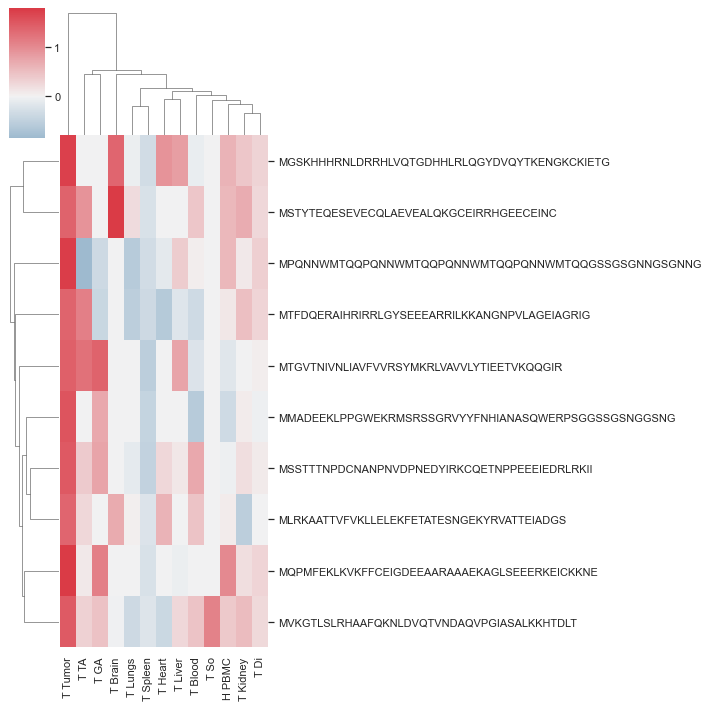

In [155]:
tumor_mice_tumtu_enrich_top_x_all_df_spleen_sort = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Spleen")

tumor_mice_tumtu_enrich_top_x_all_df_spleen_sort_bottom_x = tumor_mice_tumtu_enrich_top_x_all_df_spleen_sort.head(10)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_spleen_sort_bottom_x, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

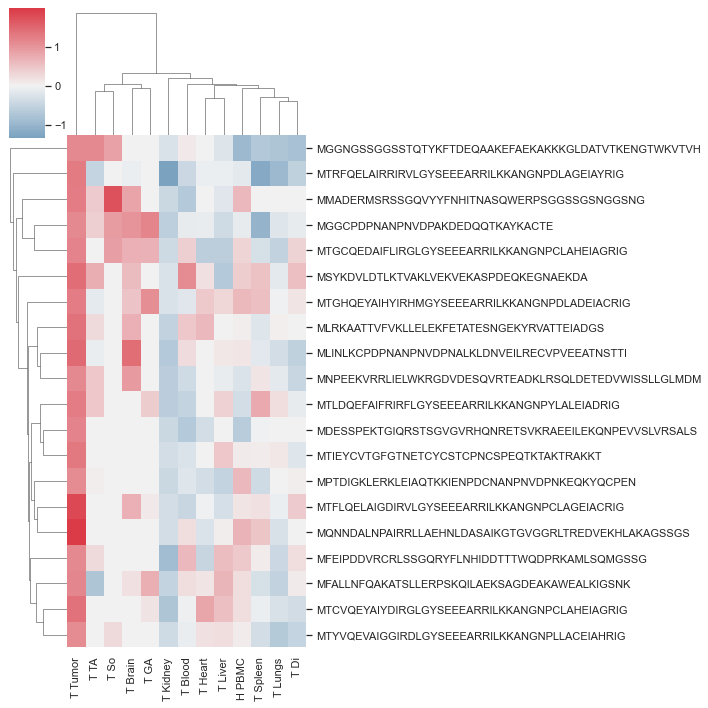

In [163]:
#tumtu_enrich_top_x_df = tumtu_enrich_df.tail(300)

tumor_mice_tumtu_enrich_top_x_all_df_kidney_sort = tumor_mice_tumtu_enrich_top_x_all_df.sort_values(by="T Kidney")

tumor_mice_tumtu_enrich_top_x_all_df_kidney_sort_bottom_x = tumor_mice_tumtu_enrich_top_x_all_df_kidney_sort.head(20)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_top_x_all_df_kidney_sort_bottom_x, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

### *** Tumor vs dose, minimizing all other organs only if positive ***

In [36]:
tumtu_enrich_dict,  tumtu_enrich_df = enrich('19-tu', '33-ds', 5)

tumtu_enrich_and_organs_dict, tumtu_enrich_and_organs_df = add_all_organs_to_enrich_df(tumtu_enrich_df)

In [37]:
tumtu_enrich_dict['MDKDSVEAAIELLLAAGDEDSAREAAKEAGLTEEDLRRLKKRVS']

[2.768079178177577, 0.4421785085281472, 0.0004568906916879325]

In [38]:
tumtu_enrich_and_organs_df

H Brain   T Brain  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.067708  0.441672   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS        0.000000  0.000000   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.000000  0.000000   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.000000  0.000000   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG        0.000000  0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000  0.238011   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.555307  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.000000  0.000000   

                                                    H Brain - 1hr   H Heart  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                0.000000 -0.526739   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             0.267337 -0.117594   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             0.000000 -0.070883   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      0.522235 -0.059602   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS                    0.000000  0.560187   
...                                                           ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG             0.590204 -0.342149   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...       0.000000  0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE             0.000000 -0.296391   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG              0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG                   0.000000  0.082370   

                                                     T Heart  H Heart - 1hr  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN          -0.216672      -0.593821   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.486294      -0.192502   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.382034       0.513975   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.258433       0.071616   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000       0.078565   
...                                                      ...            ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.291719       0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000       0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.000000       0.097048   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000       0.659436   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG             -0.136046      -0.483232   

                                                    H Kidney  T Kidney  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.002492 -0.076144   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.000119 -0.178275   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.150056 -0.185008   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.374697  0.071603   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.057612  0.169267   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.073667  0.150784   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE       -0.032788  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.107091 -0.133213   

                                                    H Kidney - 1hr   H Liver  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                 0.009233  0.036919   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             -0.207143  0.118780   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             -0.100576  0.208957   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      

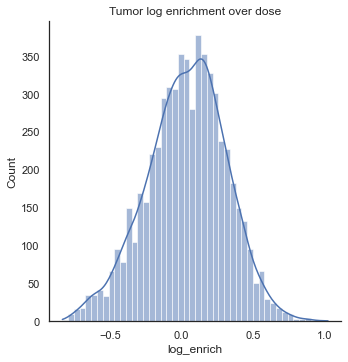

In [185]:
tumor_hist = sns.displot(data=tumtu_enrich_df, x="log_enrich", kde=True).set(title='Tumor log enrichment over dose')
tumor_hist.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/tumor_enrich_displot.png")


In [28]:

limit = 0.45
# Select column 'C' from the dataframe
column = tumtu_enrich_df['log_enrich']
# Get count of values greater than 20 in the column 'C' 
count = column[column > limit].count()
count

334

In [39]:
tumtu_enrich_and_organs_df.columns

Index(['H Brain', 'T Brain', 'H Brain - 1hr', 'H Heart', 'T Heart',
       'H Heart - 1hr', 'H Kidney', 'T Kidney', 'H Kidney - 1hr', 'H Liver',
       'T Liver', 'H Liver - 1hr', 'H Lungs', 'T Lungs', 'H Spleen',
       'T Spleen', 'H Spleen - 1hr', 'T Tumor', 'H TA', 'T TA', 'H TA - 1hr',
       'H GA', 'T GA', 'H GA - 1hr', 'H So', 'T So', 'H So - 1hr', 'H Di',
       'T Di', 'H Di - 1hr', 'H Blood', 'T Blood', 'H PBMC'],
      dtype='object')

In [40]:


#(columns = {                                         0: "H Brain", 1: "T Brain", 2: "H Brain - 1hr", 
#                                                     3: "H Heart", 4: "T Heart", 5: "H Heart - 1hr",
#                                                     6: "H Kidney", 7: "T Kidney", 8: "H Kidney - 1hr",
#                                                     9: "H Liver", 10: "T Liver", 11: "H Liver - 1hr",
#                                                     12: "H Lungs", 13: "T Lungs", 
#                                                     14: "H Spleen", 15: "T Spleen", 16: "H Spleen - 1hr", 
 #                                                    17: "T Tumor", 
 #                                                    18: "H TA", 19: "T TA", 20: "H TA - 1hr",
 #                                                    21: "H GA", 22: "T GA", 23: "H GA - 1hr", 
 #                                                    24: "H So", 25: "T So", 26: "H So - 1hr",
 #                                                    27: "H Di", 28: "T Di", 29: "H Di - 1hr",
 #                                                    30: "H Blood", 31: "T Blood", 32: "H PBMC"})

tumtu_enrich_and_organs_sums_dict = {}

for i in tumtu_enrich_and_organs_dict:
    value_list = tumtu_enrich_and_organs_dict[i]
    healthy_organ_sum = 0
    tumor_organ_sum = 0
    healthy_organ_sum_list = [np.float64(value_list[0]),np.float64(value_list[3]),np.float64(value_list[6]),np.float64(value_list[9]), \
                                np.float64(value_list[12]),np.float64(value_list[14]),value_list[18],value_list[21],(np.float64(value_list[24])),value_list[27],value_list[30],value_list[32]]
    # if the value is positive, count it. don't get any benefit for negatives.
    for j in healthy_organ_sum_list:
        if j > 0:
            healthy_organ_sum =+ j
    value_list.append(healthy_organ_sum)
    # add the sum of the tumor organs as a new value, only if they're positive
    tumor_organ_sum_list = [value_list[1],value_list[4],value_list[7],value_list[10],value_list[13],\
                            value_list[15],value_list[19],value_list[22],value_list[25],value_list[28],value_list[31]]
    for k in tumor_organ_sum_list:
        if k > 0:
            tumor_organ_sum += k
    
    value_list.append(tumor_organ_sum)
    tumtu_enrich_and_organs_sums_dict[i] = value_list

In [19]:
tumtu_enrich_and_organs_sums_dict['MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN']

[0.15590348137408253,
 1.0169868261908204,
 0,
 -1.2128618957993071,
 -0.4989068388289962,
 -1.36732439320377,
 0.005737235803715513,
 -0.17532848345022692,
 0.02125898412918886,
 0.08500903538785372,
 -0.013849463213283621,
 0.22480510138428267,
 -0.8224137526890416,
 -1.100818224385362,
 0.4046011447743051,
 0.386351641175842,
 -0.23792249927317993,
 -0.09791009782266934,
 0.0239073734868383,
 -1.1112706216719894,
 -0.2925238814284981,
 -1.546531302473852,
 0.4129283997699238,
 -0.5011445895690804,
 0,
 -0.6790965460881013,
 -0.5302276895448119,
 -0.19284588136192257,
 0.2369980319062531,
 0.12589608850898187,
 -0.6826486604049941,
 -0.37943429324143624,
 0.18014303155274347,
 0.18014303155274347,
 2.0532648990428393]

In [41]:
tumtu_enrich_and_organs_sums_df = pd.DataFrame.from_dict(tumtu_enrich_and_organs_sums_dict)

tumtu_enrich_and_organs_sums_df = tumtu_enrich_and_organs_sums_df.transpose()

tumtu_enrich_and_organs_sums_df = tumtu_enrich_and_organs_sums_df.rename(columns = {0: "H Brain", 1: "T Brain", 2: "H Brain - 1hr", 
                                                     3: "H Heart", 4: "T Heart", 5: "H Heart - 1hr",
                                                     6: "H Kidney", 7: "T Kidney", 8: "H Kidney - 1hr",
                                                     9: "H Liver", 10: "T Liver", 11: "H Liver - 1hr",
                                                     12: "H Lungs", 13: "T Lungs", 
                                                     14: "H Spleen", 15: "T Spleen", 16: "H Spleen - 1hr", 
                                                     17: "T Tumor", 
                                                     18: "H TA", 19: "T TA", 20: "H TA - 1hr",
                                                     21: "H GA", 22: "T GA", 23: "H GA - 1hr", 
                                                     24: "H So", 25: "T So", 26: "H So - 1hr",
                                                     27: "H Di", 28: "T Di", 29: "H Di - 1hr",
                                                     30: "H Blood", 31: "T Blood", 32: "H PBMC", 33: "H organ sum", 34:"T organ sum"})

tumtu_enrich_and_organs_sums_df

H Brain   T Brain  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.067708  0.441672   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS        0.000000  0.000000   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.000000  0.000000   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.000000  0.000000   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG        0.000000  0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000  0.238011   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.555307  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.000000  0.000000   

                                                    H Brain - 1hr   H Heart  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                0.000000 -0.526739   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             0.267337 -0.117594   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             0.000000 -0.070883   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      0.522235 -0.059602   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS                    0.000000  0.560187   
...                                                           ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG             0.590204 -0.342149   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...       0.000000  0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE             0.000000 -0.296391   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG              0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG                   0.000000  0.082370   

                                                     T Heart  H Heart - 1hr  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN          -0.216672      -0.593821   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.486294      -0.192502   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.382034       0.513975   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.258433       0.071616   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000       0.078565   
...                                                      ...            ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.291719       0.000000   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.000000       0.000000   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE        0.000000       0.097048   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000       0.659436   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG             -0.136046      -0.483232   

                                                    H Kidney  T Kidney  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN           0.002492 -0.076144   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS       -0.000119 -0.178275   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG        0.150056 -0.185008   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                 0.374697  0.071603   
MTIYYYVTGFGTNETCYSPPNASEEDQKKCEKKYKDS               0.000000  0.000000   
...                                                      ...       ...   
MTHFQEGAIFGIRCLGYSEEEARRILKKANGNPVLAREIAGRIG       -0.057612  0.169267   
MHSPNFIAHTHSPNFIAHTHSPNFIAHTSGGNNGSNNNSSSSSGGGN...  0.073667  0.150784   
MALDLFGLALAAQVKAQDRRLVAIQEATGQAADRPAADRYSAHE       -0.032788  0.000000   
MTDSGTCVFFIRGLGYSEEEARRILKKANGNPCLAYEIAVRIG         0.000000  0.000000   
MADCKCDVNGLTFIVTSSEQCEKLCRQAGVTNCRVHCG              0.107091 -0.133213   

                                                    H Kidney - 1hr   H Liver  \
MTDVYIFTDEREARRFEQEARDNGKDVQVYEVAGQFVVISN                 0.009233  0.036919   
MDALEDERKAKEAVERGDRDKARKLLQKAGLSPEQAEKVIQALS             -0.207143  0.118780   
MTYDQEFAIGCIRRLGYSEEEARRILKKANGNPDLAREIAFRIG             -0.100576  0.208957   
MDKEKCCEEIMKRCKKRGITDVEDVVVCNNEEVQC                      

In [44]:
tumor_mice_tumtu_enrich_and_organs_sums_df = tumtu_enrich_and_organs_sums_df.copy()

tumor_mice_tumtu_enrich_and_organs_sums_df = tumor_mice_tumtu_enrich_and_organs_sums_df[['T Brain', 'T Heart', 'T Kidney', 'T Liver', 'T Lungs', 'T Spleen', 'T Tumor', 'T TA', 'T GA', 'T So', 'T Di', 'T Blood']]

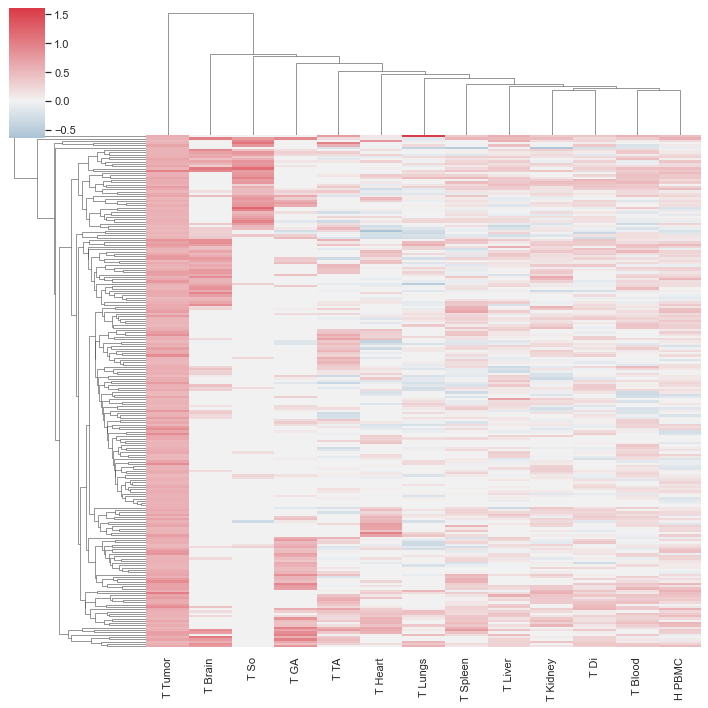

In [190]:
tumor_mice_tumtu_enrich_and_organs_sums_df_tumor_top = tumor_mice_tumtu_enrich_and_organs_sums_df.sort_values(by="T Tumor").tail(222)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_mice_tumtu_enrich_and_organs_sums_df_tumor_top, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)

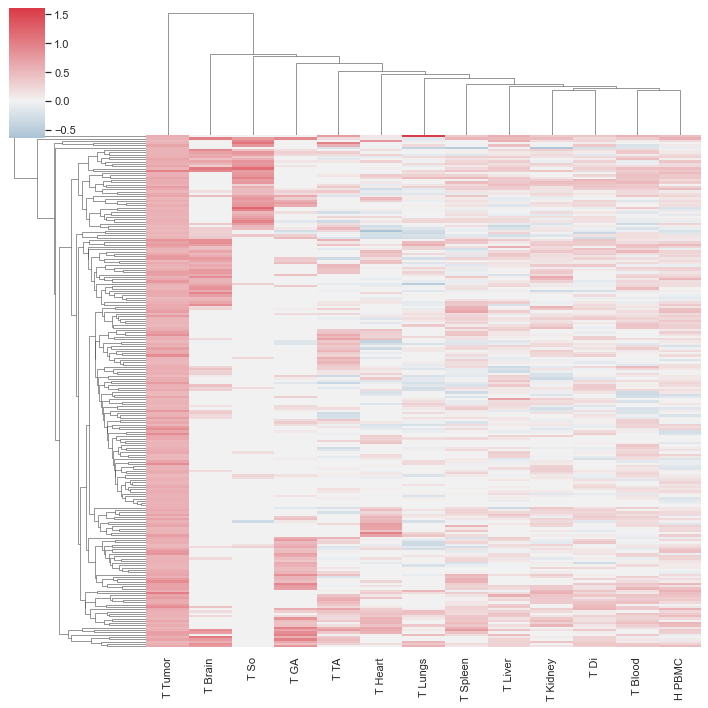

In [191]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(tumor_mice_tumtu_enrich_and_organs_sums_df_tumor_top, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/tumor_top_222_clustermap.png")


NameError: name 'tumor_mice_tumtu_enrich_and_organs_sums_df' is not defined

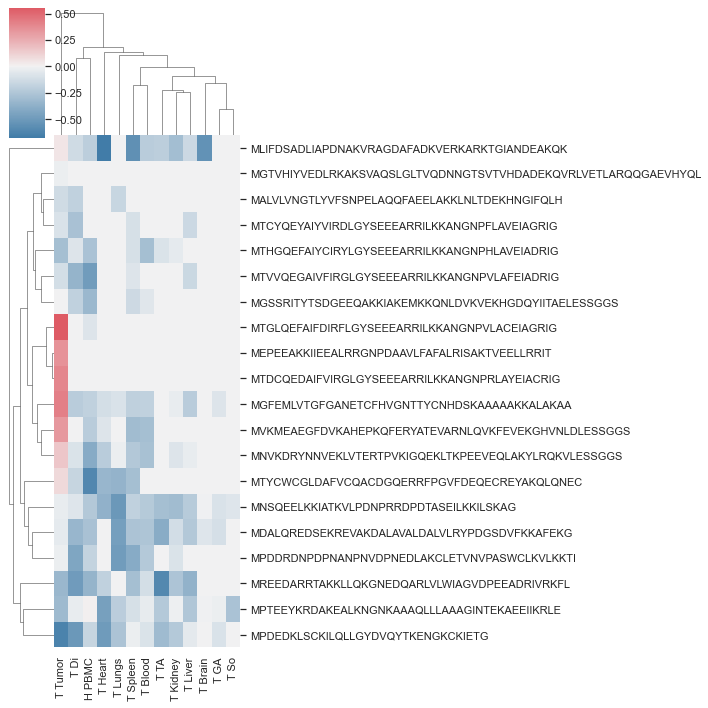

In [192]:
tumor_and_sums_organ_bottom = tumtu_enrich_and_organs_sums_df.sort_values(by="T organ sum").head(20)
tumor_and_sums_organ_bottom = tumor_and_sums_organ_bottom[['T Brain', 'T Heart', 'T Kidney', 'T Liver', 'T Lungs', 'T Spleen', 'T Tumor', 'T TA', 'T GA', 'T So', 'T Di', 'T Blood', 'H PBMC']]
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_and_sums_organ_bottom, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

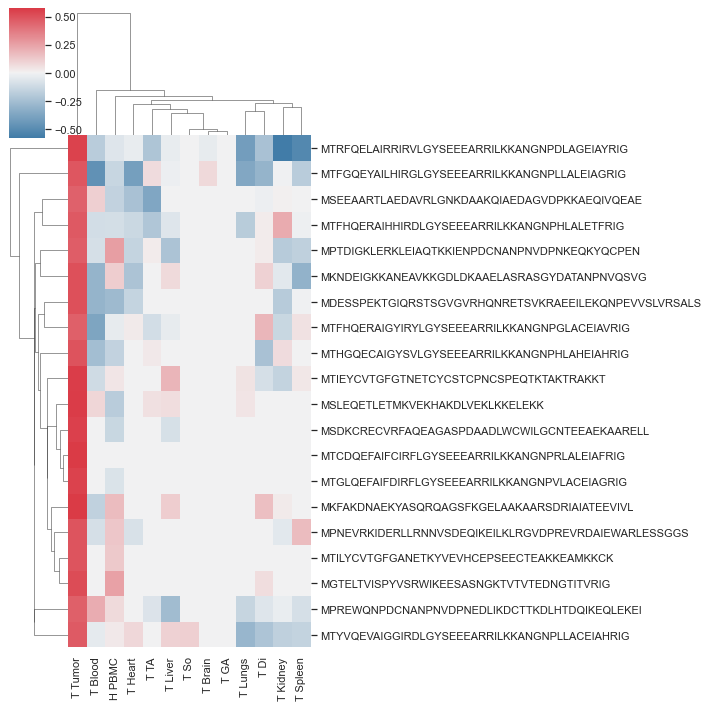

In [218]:
tumor_and_sums_tumor_top = tumtu_enrich_and_organs_sums_df.sort_values(by="T Tumor").tail(328)
tumor_and_sums_tumor_top_organ_bottom = tumor_and_sums_tumor_top.sort_values(by="T organ sum").head(20)
tumor_and_sums_tumor_top_organ_bottom = tumor_and_sums_tumor_top_organ_bottom[['T Brain', 'T Heart', 'T Kidney', 'T Liver', 'T Lungs', 'T Spleen', 'T Tumor', 'T TA', 'T GA', 'T So', 'T Di', 'T Blood', 'H PBMC']]
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(tumor_and_sums_tumor_top_organ_bottom, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

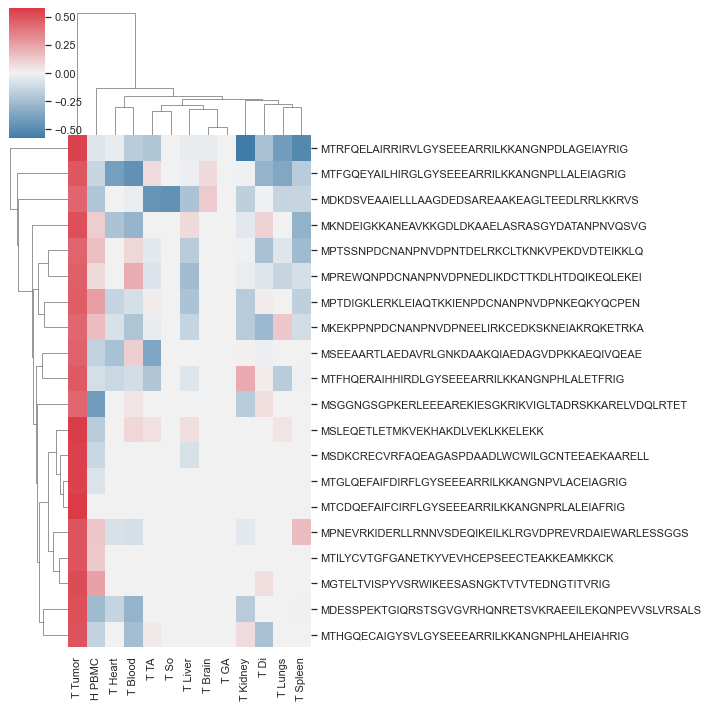

In [113]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(tumor_and_sums_tumor_top_organ_bottom, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/tumor_top_organ_min_twenty_clustermap.png")


In [28]:
tumor_and_sums_tumor_top_organ_bottom.index

Index(['MSDKCRECVRFAQEAGASPDAADLWCWILGCNTEEAEKAARELL',
       'MTILYCVTGFGANETKYVEVHCEPSEECTEAKKEAMKKCK',
       'MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG',
       'MTCDQEFAIFCIRFLGYSEEEARRILKKANGNPRLALEIAFRIG',
       'MTGLQEFAIFDIRFLGYSEEEARRILKKANGNPVLACEIAGRIG',
       'MDESSPEKTGIQRSTSGVGVRHQNRETSVKRAEEILEKQNPEVVSLVRSALS',
       'MPTDIGKLERKLEIAQTKKIENPDCNANPNVDPNKEQKYQCPEN',
       'MGTELTVISPYVSRWIKEESASNGKTVTVTEDNGTITVRIG',
       'MPTSSNPDCNANPNVDPNTDELRKCLTKNKVPEKDVDTEIKKLQ',
       'MTHGQECAIGYSVLGYSEEEARRILKKANGNPHLAHEIAHRIG',
       'MSGGNGSGPKERLEEEAREKIESGKRIKVIGLTADRSKKARELVDQLRTET',
       'MSEEAARTLAEDAVRLGNKDAAKQIAEDAGVDPKKAEQIVQEAE',
       'MDKDSVEAAIELLLAAGDEDSAREAAKEAGLTEEDLRRLKKRVS',
       'MKEKPPNPDCNANPNVDPNEELIRKCEDKSKNEIAKRQKETRKA',
       'MTFGQEYAILHIRGLGYSEEEARRILKKANGNPLLALEIAGRIG',
       'MPNEVRKIDERLLRNNVSDEQIKEILKLRGVDPREVRDAIEWARLESSGGS',
       'MKNDEIGKKANEAVKKGDLDKAAELASRASGYDATANPNVQSVG',
       'MPREWQNPDCNANPNVDPNEDLIKDCTTKDLHTDQIKEQLEKE

In [143]:
tumor_and_sums_tumor_top_organ_bottom.loc['MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG']

T Brain    -0.032070
T Heart    -0.027656
T Kidney   -0.576215
T Liver    -0.027852
T Lungs    -0.410459
T Spleen   -0.516804
T Tumor     0.554566
T TA       -0.219602
T GA        0.000000
T So        0.000000
T Di       -0.236732
T Blood    -0.180960
H PBMC     -0.060262
Name: MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG, dtype: float64

In [ ]:
# heatmaps just for tumor hits 

### Tumor hits only heatmaps

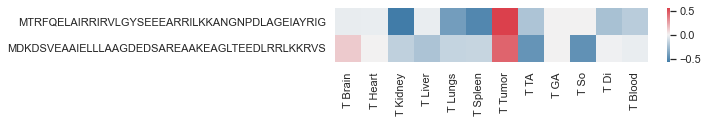

In [46]:
# get lung hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

tumor_hits_df = pd.DataFrame()

tumor_hits_df['MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG'] = tumor_mice_tumtu_enrich_and_organs_sums_df.loc['MTRFQELAIRRIRVLGYSEEEARRILKKANGNPDLAGEIAYRIG']
tumor_hits_df['MDKDSVEAAIELLLAAGDEDSAREAAKEAGLTEEDLRRLKKRVS'] = tumor_mice_tumtu_enrich_and_organs_sums_df.loc['MDKDSVEAAIELLLAAGDEDSAREAAKEAGLTEEDLRRLKKRVS']

tumor_hits_df = tumor_hits_df.T

plt.figure(figsize = (7,1))
    
tumor_hits_fig = sns.heatmap(tumor_hits_df,xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

tumor_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/tumor_hits_fig.svg", bbox_inches="tight")
tumor_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/tumor_hits_fig.png", bbox_inches="tight")


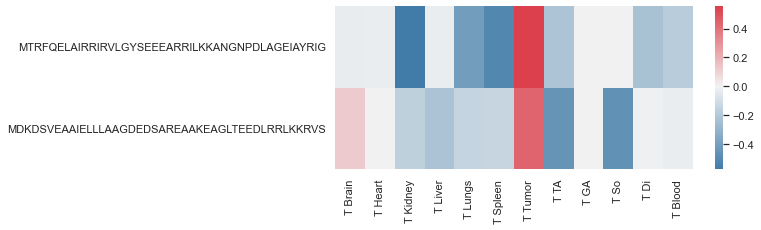

In [50]:
plt.figure(figsize = (8,3))
    
tumor_hits_fig = sns.heatmap(tumor_hits_df,xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

tumor_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/tumor_hits_fig_legend.svg", bbox_inches="tight")
tumor_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/tumor_hits_fig_legend.png", bbox_inches="tight")


### *** Heart vs dose ***

In [15]:
#helhe_enrich_dict,  helhe_enrich_df = enrich('04-he', '33-ds', 5)

helhe_enrich_df = helhe_enrich_df.sort_values(by="log_enrich")
helhe_enrich_df

count_i  count_f      enrich  \
MTDVYIFTDEREARRFEQEIRDNGKDVQVYEVDGQFVVISN        63.0      5.0    0.092250   
MPTVTLRNADPTAVQEVAERAKRANVSEIHIDG                86.0      7.0    0.094610   
MTTEYTVTDDQKAREIYEELAKQNHNGTDHIKVD               61.0      5.0    0.095275   
MPDEDKLSCKILQLLGYDVQYTKENGKCKIETG                53.0      5.0    0.109656   
MPADPDPNANPNVQPAKRPTEQDDACKSSCEK                 52.0      5.0    0.111764   
...                                               ...      ...         ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN     20.0   1779.0  103.390942   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE     21.0   2054.0  113.688801   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS      9.0    954.0  123.208993   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK     23.0   2455.0  124.068120   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG      6.0    723.0  140.063053   

                                              charge    hp  chg_vs_len  \
MTDVYIFTDEREARRFEQEIRDNGKDVQVYEVDGQFVVISN      -5.00 -29.2   -0.121951   
MPTVTLRNADPTAVQEVAERAKRANVSEIHIDG              -0.75 -14.6   -0.022727   
MTTEYTVTDDQKAREIYEELAKQNHNGTDHIKVD             -3.50 -44.4   -0.102941   
MPDEDKLSCKILQLLGYDVQYTKENGKCKIETG              -1.00 -23.3   -0.030303   
MPADPDPNANPNVQPAKRPTEQDDACKSSCEK               -2.00 -48.3   -0.062500   
...                                              ...   ...         ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN   -4.00 -33.5   -0.090909   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE   -2.00  -9.1   -0.045455   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS   -1.00 -17.7   -0.022727   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK   -4.00 -29.1   -0.090909   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG   -2.00 -19.6   -0.045455   

                                              hp_vs_len  pI at pH 7.4  \
MTDVYIFTDEREARRFEQEIRDNGKDVQVYEVDGQFVVISN     -0.712195     -5.714893   
MPTVTLRNADPTAVQEVAERAKRANVSEIHIDG             -0.442424     -1.676811   
MTTEYTVTDDQKAREIYEELAKQNHNGTDHIKVD            -1.305882     -4.646873   
MPDEDKLSCKILQLLGYDVQYTKENGKCKIETG             -0.706061     -1.776956   
MPADPDPNANPNVQPAKRPTEQDDACKSSCEK              -1.509375     -2.767633   
...                                                 ...           ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN  -0.761364     -4.713772   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE  -0.206818     -2.715727   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS  -0.402273     -1.725960   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK  -0.661364     -4.721696   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG  -0.445455     -2.725286   

                                              log_enrich  
MTDVYIFTDEREARRFEQEIRDNGKDVQVYEVDGQFVVISN      -1.035034  
MPTVTLRNADPTAVQEVAERAKRANVSEIHIDG              -1.024064  
MTTEYTVTDDQKAREIYEELAKQNHNGTDHIKVD             -1.021023  
MPDEDKLSCKILQLLGYDVQYTKENGKCKIETG              -0.959969  
MPADPDPNANPNVQPAKRPTEQDDACKSSCEK               -0.951697  
...                                                  ...  
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN    2.014482  
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE    2.055718  
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS    2.090642  
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK    2.093660  
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG    2.146324  

[5720 rows x 9 columns]

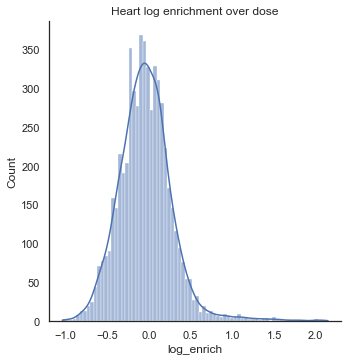

In [16]:
heart_hist = sns.displot(data=helhe_enrich_df, x="log_enrich", kde=True).set(title='Heart log enrichment over dose')
#heart_hist.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helhe_enrich_displot.png")

In [17]:
#sns.displot(data=helhe_enrich_df, x="log_enrich", kde=True).set(title='Heart log enrichment over dose')


limit = 0.5
# Select column 'C' from the dataframe
column = helhe_enrich_df['log_enrich']
# Get count of values greater than 20 in the column 'C' 
count = column[column > limit].count()
count

243

In [16]:
helhe_enrich_top_x_df = helhe_enrich_df.tail(243)
helhe_enrich_top_x_df

count_i  count_f  \
MTFLQEDAICLIRDLGYSEEEARRILKKANGNPGLAREIADRIG           22.0     60.0   
MDKEKCCEEIMKRCKKRGITDVECHGDVVVCNNEEVQC                 11.0     30.0   
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE           11.0     30.0   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK           11.0     30.0   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...      8.0     22.0   
...                                                     ...      ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN           20.0   1779.0   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE           21.0   2054.0   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS            9.0    954.0   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK           23.0   2455.0   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG            6.0    723.0   

                                                        enrich  charge    hp  \
MTFLQEDAICLIRDLGYSEEEARRILKKANGNPGLAREIADRIG          3.170043   -1.00 -17.1   
MDKEKCCEEIMKRCKKRGITDVECHGDVVVCNNEEVQC                3.170043   -1.75 -26.4   
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE          3.170043   -4.00  -7.1   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK          3.170043   -4.00 -28.6   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...    3.196460    0.00 -43.5   
...                                                        ...     ...   ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN        103.390942   -4.00 -33.5   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE        113.688801   -2.00  -9.1   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS        123.208993   -1.00 -17.7   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK        124.068120   -4.00 -29.1   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG        140.063053   -2.00 -19.6   

                                                    chg_vs_len  hp_vs_len  \
MTFLQEDAICLIRDLGYSEEEARRILKKANGNPGLAREIADRIG         -0.022727  -0.388636   
MDKEKCCEEIMKRCKKRGITDVECHGDVVVCNNEEVQC               -0.046053  -0.694737   
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE         -0.090909  -0.161364   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK         -0.090909  -0.650000   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...    0.000000  -0.852941   
...                                                        ...        ...   
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN         -0.090909  -0.761364   
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE         -0.045455  -0.206818   
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS         -0.022727  -0.402273   
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK         -0.090909  -0.661364   
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG         -0.045455  -0.445455   

                                                    pI at pH 7.4  log_enrich  
MTFLQEDAICLIRDLGYSEEEARRILKKANGNPGLAREIADRIG           -1.740314    0.501065  
MDKEKCCEEIMKRCKKRGITDVECHGDVVVCNNEEVQC                 -2.830019    0.501065  
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE           -4.720014    0.501065  
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK           -4.713555    0.501065  
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...     -0.713813    0.504669  
...                                                          ...         ...  
MKAAELLEQDAEALQRGDEDTAKEVARRLGLSDEDLKSLRSALN           -4.713772    2.014482  
MSDDTLLKWALFAIRQGDEEFVRIVAKTLGVSPEDVKELAKRAE           -2.715727    2.055718  
MDEEKALIAIADALANGNEDKARNIAKKAGLDPKAVDEIKKLLS           -1.725960    2.090642  
MDKAEAEIYAAFALAEGNEDEARKALKEAGVNPEEVEKAIQKLK           -4.721696    2.093660  
MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG           -2.725286    2.146324  

[243 rows x 9 columns]

In [17]:
helhe_enrich_top_x_df = helhe_enrich_top_x_df.sort_index()

In [44]:
print(helhe_enrich_top_x_df.loc['MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG'])

count_i           6.000000
count_f         723.000000
enrich          140.063053
charge           -2.000000
hp              -19.600000
chg_vs_len       -0.045455
hp_vs_len        -0.445455
pI at pH 7.4     -2.725286
log_enrich        2.146324
Name: MDPSLEKFVKLAADLGLSKEQIKDALRALGYSDEEAEKAINKAG, dtype: float64


In [18]:
helhe_enrich_top_x_df

count_i  count_f  \
MADHAELVARAAQKNGVSPDDAEYAAQLLGVSPEEAKEIAKKIK            5.0     14.0   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK           11.0     30.0   
MAGWYHDPLGTPGLLRYWNGAQWTQATRAAEEAGVASGGNGSGGNGS...      8.0     22.0   
MARTAHNPDCNANPNVDPNEPKEEECPKLELTLKKVIEKVTNSK           12.0     37.0   
MCRVQCDTTTETYTITTHLDCVQVIEECLRKC                       13.0     43.0   
...                                                     ...      ...   
MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG           13.0    102.0   
MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG            8.0    129.0   
MTYTYTTTDYTEADKWAKWAAKVKASLRVEVSNGTDENNSD              20.0     96.0   
MTYYQELAIVGIRDLGYSEEEARRILKKANGNPVLAVEIACRIG            6.0     17.0   
MVKGTLSLRHAAFQKNLDVQTVNDAQVPGIASALKKHTDLT              29.0    104.0   

                                                       enrich  charge    hp  \
MADHAELVARAAQKNGVSPDDAEYAAQLLGVSPEEAKEIAKKIK         3.254577   -1.75 -19.7   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK         3.170043   -4.00 -28.6   
MAGWYHDPLGTPGLLRYWNGAQWTQATRAAEEAGVASGGNGSGGNGS...   3.196460   -0.75 -32.6   
MARTAHNPDCNANPNVDPNEPKEEECPKLELTLKKVIEKVTNSK         3.583909   -0.75 -50.2   
MCRVQCDTTTETYTITTHLDCVQVIEECLRKC                     3.844693   -1.75  -3.2   
...                                                       ...     ...   ...   
MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG         9.119969    0.00 -13.2   
MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG        18.742877    0.25 -16.5   
MTYTYTTTDYTEADKWAKWAAKVKASLRVEVSNGTDENNSD            5.579275   -2.00 -41.2   
MTYYQELAIVGIRDLGYSEEEARRILKKANGNPVLAVEIACRIG         3.293322    0.00  -2.2   
MVKGTLSLRHAAFQKNLDVQTVNDAQVPGIASALKKHTDLT            4.168424    2.50  -7.3   

                                                    chg_vs_len  hp_vs_len  \
MADHAELVARAAQKNGVSPDDAEYAAQLLGVSPEEAKEIAKKIK         -0.039773  -0.447727   
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK         -0.090909  -0.650000   
MAGWYHDPLGTPGLLRYWNGAQWTQATRAAEEAGVASGGNGSGGNGS...   -0.014706  -0.639216   
MARTAHNPDCNANPNVDPNEPKEEECPKLELTLKKVIEKVTNSK         -0.017045  -1.140909   
MCRVQCDTTTETYTITTHLDCVQVIEECLRKC                     -0.054688  -0.100000   
...                                                        ...        ...   
MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG          0.000000  -0.300000   
MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG          0.005682  -0.375000   
MTYTYTTTDYTEADKWAKWAAKVKASLRVEVSNGTDENNSD            -0.048780  -1.004878   
MTYYQELAIVGIRDLGYSEEEARRILKKANGNPVLAVEIACRIG          0.000000  -0.050000   
MVKGTLSLRHAAFQKNLDVQTVNDAQVPGIASALKKHTDLT             0.060976  -0.178049   

                                                    pI at pH 7.4  log_enrich  
MADHAELVARAAQKNGVSPDDAEYAAQLLGVSPEEAKEIAKKIK           -2.686600    0.512495  
MAEAFLKLARSAGEKEVKAAEEFEDRITNAQEAGVEEALRLEQK           -4.713555    0.501065  
MAGWYHDPLGTPGLLRYWNGAQWTQATRAAEEAGVASGGNGSGGNGS...     -1.680858    0.504669  
MARTAHNPDCNANPNVDPNEPKEEECPKLELTLKKVIEKVTNSK           -1.734933    0.554357  
MCRVQCDTTTETYTITTHLDCVQVIEECLRKC                       -2.801808    0.584862  
...                                                          ...         ...  
MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG           -0.718763    0.959993  
MTYLQECAIHGIRYLGYSEEEARRILKKANGNPFLAYEIADRIG           -0.712072    1.272836  
MTYTYTTTDYTEADKWAKWAAKVKASLRVEVSNGTDENNSD              -2.726258    0.746578  
MTYYQELAIVGIRDLGYSEEEARRILKKANGNPVLAVEIACRIG           -0.746193    0.517634  
MVKGTLSLRHAAFQKNLDVQTVNDAQVPGIASALKKHTDLT               1.349433    0.619972  

[243 rows x 9 columns]

In [19]:
helhe_enrich_top_x_df_paad = helhe_enrich_top_x_df.tail(175)

In [20]:
helhe_enrich_top_x_df_paad = helhe_enrich_top_x_df_paad.head(24)

In [21]:
# ALL heart
helhe_enrich_top_x_df_paad_all_dict, helhe_enrich_top_x_df_paad_all_df = add_all_organs_to_enrich_df(helhe_enrich_top_x_df_paad)
helhe_enrich_top_x_df_paad_all_df = helhe_enrich_top_x_df_paad_all_df[['H Brain', 'H Heart', 'H Kidney', 'H Liver', 'H Lungs', 'H Spleen', 'H TA', 'H GA', 'H So', 'H Di', 'H Blood', 'H PBMC']]

In [22]:
helhe_enrich_top_x_df_paad.sort_values(by="enrich")

count_i  count_f  \
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE           11.0     30.0   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...      8.0     22.0   
MPALDLAFYAWFAVANGDRKTAKELLEKAGYDPEEAEQIIKDIE            6.0     17.0   
MPALDLAFYAGCGSKWGQKTAKELLEKAGYSPEEREQIIKDIE            10.0     29.0   
MPALDLAFYAWNAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE           25.0     76.0   
MPALDLAFYAWFAVQNGDRKTAKELLESAGYSPEEAEQIIKDIE            8.0     25.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYSQEEAEQIIKDIE            8.0     27.0   
MPALDLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEQIIKDIE           10.0     35.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYQPEEAEQIIKDIE           10.0     37.0   
MPAADLAFYAWFAMANGDRKTAKELLEKAGYSPEEAEQIIKDIE           16.0     61.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKKGYSPEEAEQIIKDIE            6.0     23.0   
MPALDLAFYAWFAVANGDRKQAKELLEKAGYSPEEAEQIIKDIE            6.0     23.0   
MPALDLAFYAWFAVQNGDRKTAKELLERAGYSPEEAEQIIKDIE           15.0     58.0   
MPAMDLAFYAWFAVQNGDRKTAKELLEKLGYSPEEAEQIIKDIE           11.0     43.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYSPAEAEQIIKDIE           12.0     47.0   
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAFQIIKDIE            5.0     22.0   
MPALDLAFYAWFAVANGDRKTAKELLEKRGYSPEEAEQIIKDIE            8.0     37.0   
MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE           22.0    158.0   
MPAADLAFYAWFAVANGDRKTAKELLEKQGYSPEEAEQIIKDIE           15.0    112.0   
MPALDLAFYEWFAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE           16.0    149.0   
MPALDLAFYAWFAGQNGDRKTAKELLEKAGYSPEEAEQIIKDIE            9.0     84.0   
MPALDLAFYAWFAVQNGDRKTAKKLLEKAGYSPEEAEQIIKDIE           11.0    104.0   
MPAADLAFYAWFAVANGDRKTAKALLEKAGYSPEEAEQIIKDIE           10.0    131.0   
MPAADLAFYAWFAGANGDRKTAKELLEKAGYSPEEAEQIIKDIE           13.0    223.0   

                                                       enrich  charge    hp  \
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE         3.170043    -4.0  -7.1   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...   3.196460     0.0 -43.5   
MPALDLAFYAWFAVANGDRKTAKELLEKAGYDPEEAEQIIKDIE         3.293322    -5.0 -15.5   
MPALDLAFYAGCGSKWGQKTAKELLEKAGYSPEEREQIIKDIE          3.370812    -2.0 -24.7   
MPALDLAFYAWNAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE         3.533541    -4.0 -24.4   
MPALDLAFYAWFAVQNGDRKTAKELLESAGYSPEEAEQIIKDIE         3.632341    -5.0 -15.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYSQEEAEQIIKDIE         3.922928    -4.0 -20.0   
MPALDLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEQIIKDIE         4.068221    -4.0 -12.8   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYQPEEAEQIIKDIE         4.300691    -4.0 -20.8   
MPAADLAFYAWFAMANGDRKTAKELLEKAGYSPEEAEQIIKDIE         4.431456    -4.0 -17.1   
MPALDLAFYAWFAVQNGDRKTAKELLEKKGYSPEEAEQIIKDIE         4.455671    -3.0 -23.8   
MPALDLAFYAWFAVANGDRKQAKELLEKAGYSPEEAEQIIKDIE         4.455671    -4.0 -15.6   
MPALDLAFYAWFAVQNGDRKTAKELLERAGYSPEEAEQIIKDIE         4.494416    -4.0 -18.7   
MPAMDLAFYAWFAVQNGDRKTAKELLEKLGYSPEEAEQIIKDIE         4.543728    -4.0 -18.0   
MPALDLAFYAWFAVQNGDRKTAKELLEKAGYSPAEAEQIIKDIE         4.552534    -3.0 -12.8   
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAFQIIKDIE         5.114336    -3.0  -8.5   
MPALDLAFYAWFAVANGDRKTAKELLEKRGYSPEEAEQIIKDIE         5.375864    -3.0 -19.1   
MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE         8.347779    -5.0 -22.5   
MPAADLAFYAWFAVANGDRKTAKELLEKQGYSPEEAEQIIKDIE         8.678872    -4.0 -20.1   
MPALDLAFYEWFAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE        10.824375    -5.0 -23.4   
MPALDLAFYAWFAGQNGDRKTAKELLEKAGYSPEEAEQIIKDIE        10.848591    -4.0 -22.7   
MPALDLAFYAWFAVQNGDRKTAKKLLEKAGYSPEEAEQIIKDIE        10.989481    -2.0 -18.5   
MPAADLAFYAWFAVANGDRKTAKALLEKAGYSPEEAEQIIKDIE        15.226772    -3.0  -9.5   
MPAADLAFYAWFAGANGDRKTAKELLEKAGYSPEEAEQIIKDIE        19.938756    -4.0 -19.4   

                                                    chg_vs_len  hp_vs_len  \
MPAADLAFYAWFAVANGDRKTAKELLEKAGYSPEEAEVIIKDIE         -0.090909  -0.161364   
MPAEEVEKQLTTALRRGETYRFGNWTVTSEEAARRLLKWVRNTELES...    0.000000  -0.852941   
MPALDLAFYAWFAVANGDRKTAKELLEKAGYDPEEAEQIIKDIE

In [74]:
helhe_enrich_top_x_df_paad.to_csv('/home/audreyo/documents/mini_protein_library/20230224_insulin_receptor_binder_info_from_DH/helhe_enrich_top_x_df_paad.csv')

In [75]:
helhe_enrich_top_x_df_paad_all_df.to_csv('/home/audreyo/documents/mini_protein_library/20230224_insulin_receptor_binder_info_from_DH/helhe_enrich_top_x_df_paad_all_df.csv')

<AxesSubplot:>

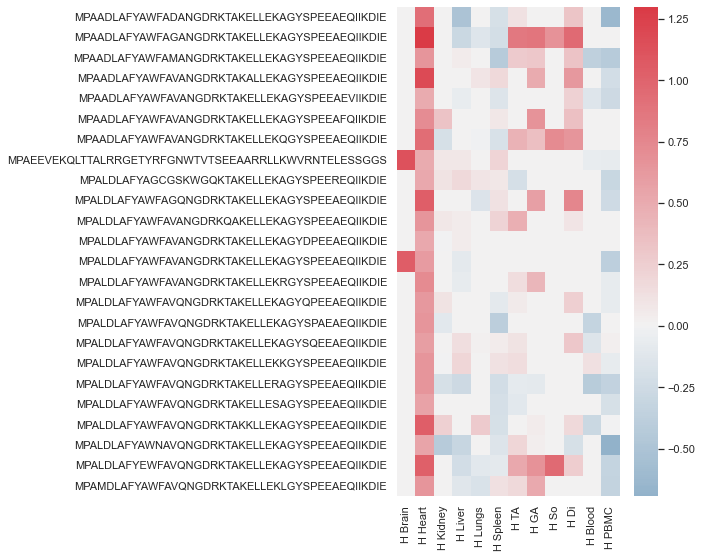

In [30]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.set(rc = {'figure.figsize':(5,9)})

sns.heatmap(helhe_enrich_top_x_df_paad_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)


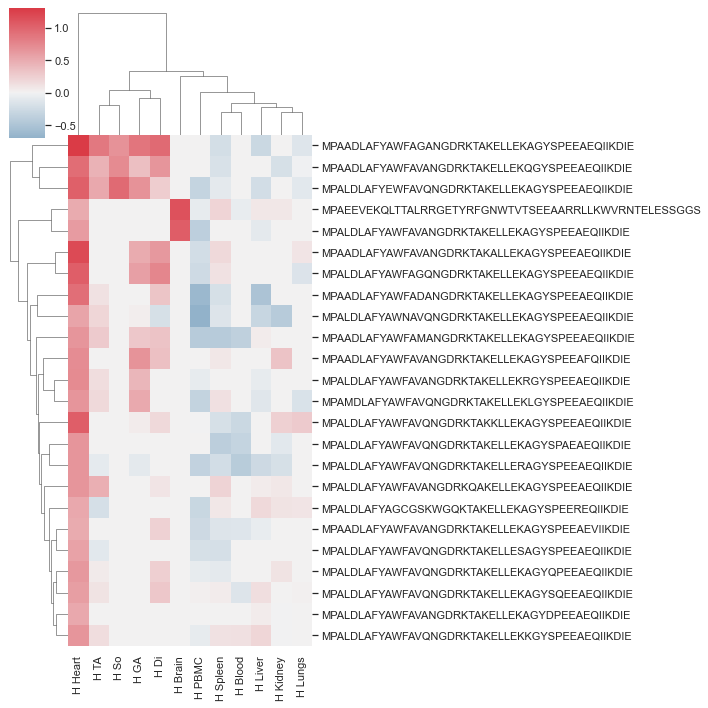

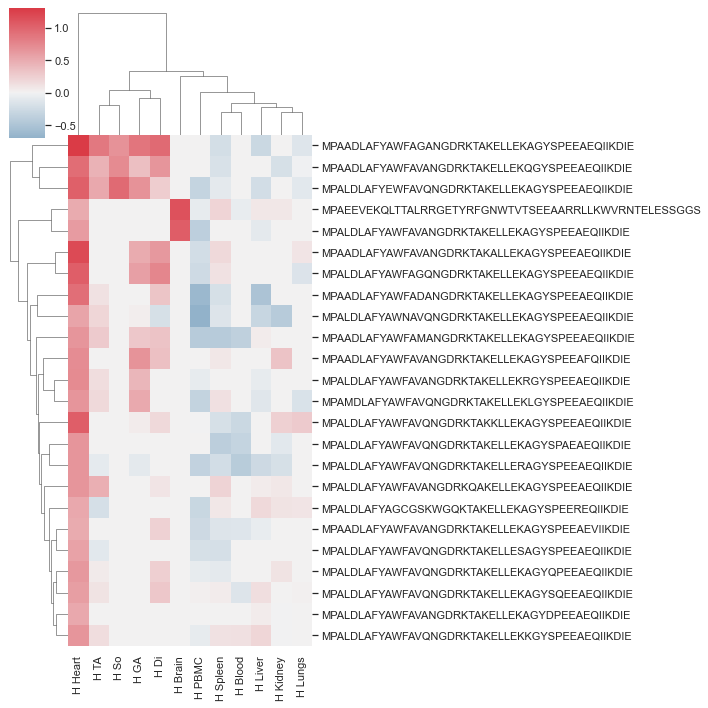

In [23]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(helhe_enrich_top_x_df_paad_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

# SAVE CLUSTERMAP

heart_mpaad_clustermap = sns.clustermap(helhe_enrich_top_x_df_paad_all_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)
heart_mpaad_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/log10_healthy_mice_helhe_enrich_top_paad_all_clustermap.png")


In [25]:
# ALL heart
helhe_enrich_all_dict, helhe_enrich_all_df = add_all_organs_to_enrich_df(helhe_enrich_df)
helhe_enrich_all_df = helhe_enrich_all_df[['H Brain', 'H Heart', 'H Kidney', 'H Liver', 'H Lungs', 'H Spleen', 'H TA', 'H GA', 'H So', 'H Di', 'H Blood', 'H PBMC']]

In [26]:
# TOP ONLY
helhe_enrich_top_x_all_dict, helhe_enrich_top_x_all_df = add_all_organs_to_enrich_df(helhe_enrich_top_x_df)

In [27]:
healthy_mice_helhe_enrich_top_x_all_df = helhe_enrich_top_x_all_df[['H Brain', 'H Heart', 'H Kidney', 'H Liver', 'H Lungs', 'H Spleen', 'H TA', 'H GA', 'H So', 'H Di', 'H Blood', 'H PBMC']]

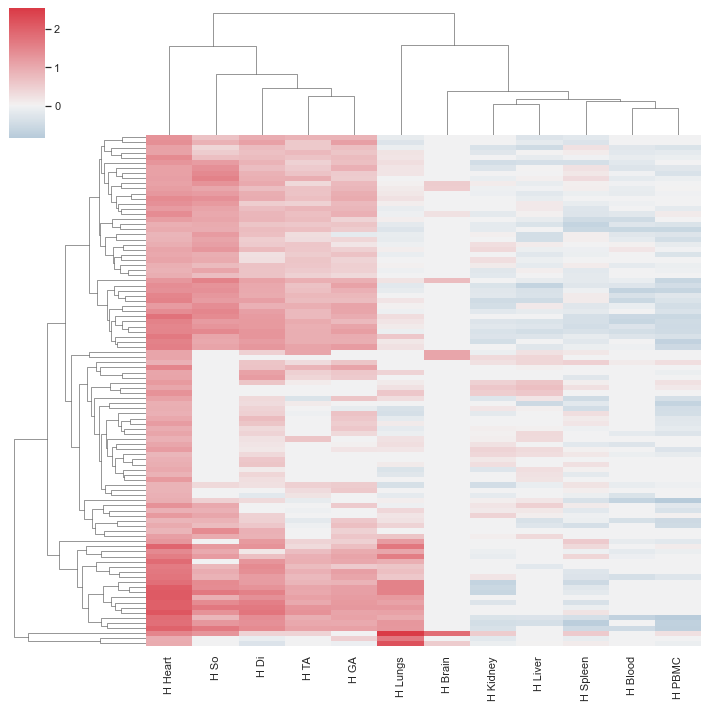

In [28]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)

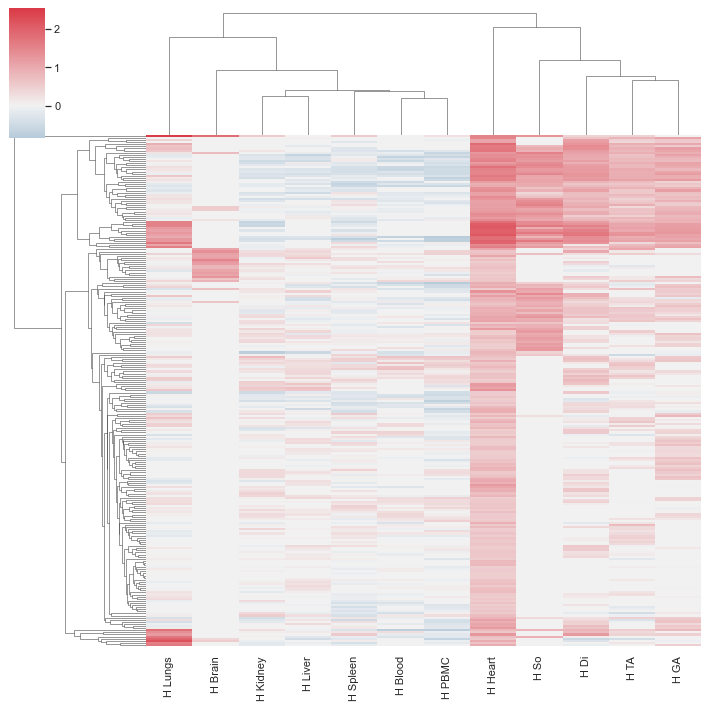

In [173]:
# SAVE CLUSTERMAP

heart_clustermap = sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)
heart_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helhe_enrich_top_243_all_clustermap.png")


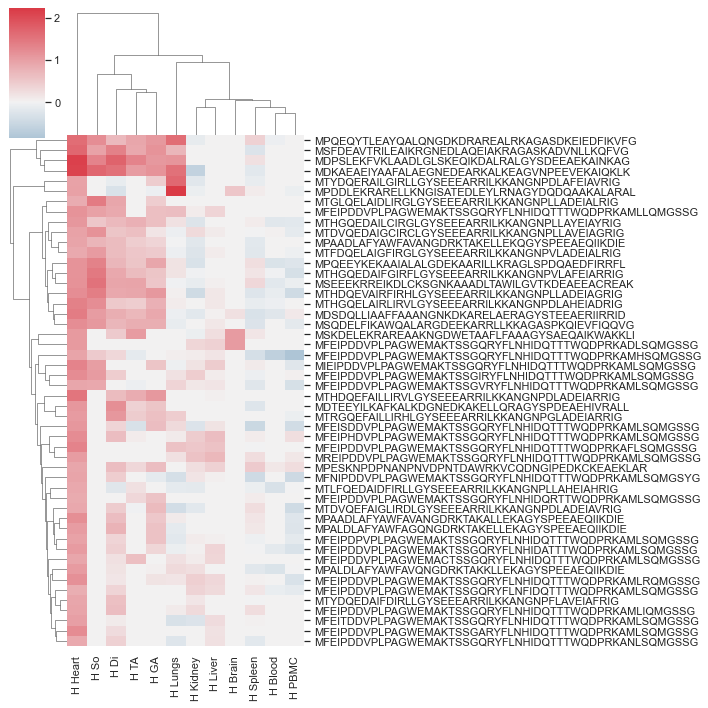

In [31]:
#healthy_mice_helhe_enrich_top_x_all_df 

healthy_mice_helhe_enrich_top_x_all_df_lisort_hi = healthy_mice_helhe_enrich_top_x_all_df.sort_values(by='H Liver')

healthy_mice_helhe_enrich_top_x_all_df_lisort_hi_top = healthy_mice_helhe_enrich_top_x_all_df_lisort_hi.tail(50)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_lisort_hi_top, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [174]:
#healthy_mice_helhe_enrich_top_x_all_df 

healthy_mice_helhe_enrich_top_x_all_df_lisort = healthy_mice_helhe_enrich_top_x_all_df.sort_values(by='H Liver')

healthy_mice_helhe_enrich_top_x_all_df_lisort_topy = healthy_mice_helhe_enrich_top_x_all_df_lisort.head(20)

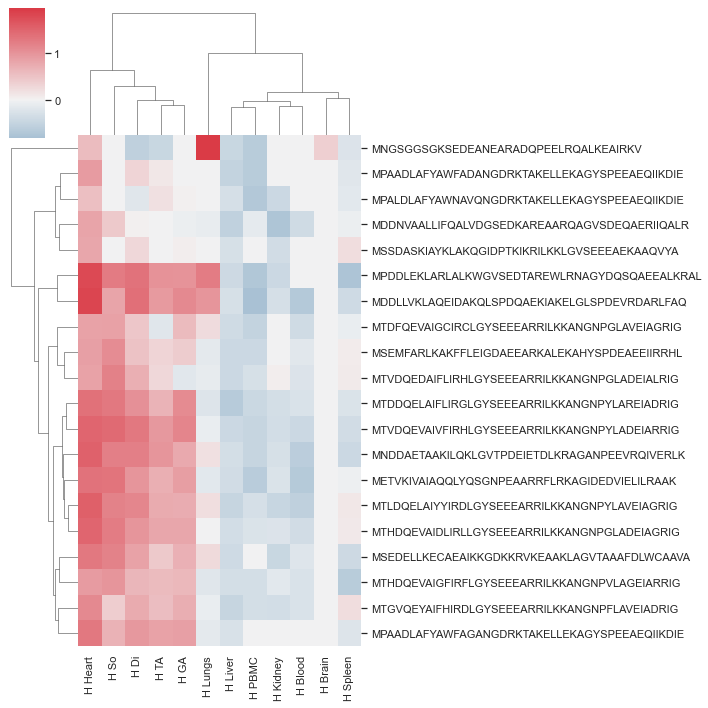

In [175]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_lisort_topy, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [78]:
healthy_mice_helhe_enrich_top_x_all_df_lisort_topy.index

Index(['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG',
       'MDDNVAALLIFQALVDGSEDKAREAARQAGVSDEQAERIIQALR',
       'MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE',
       'MTLDQELAIYYIRDLGYSEEEARRILKKANGNPYLAVEIAGRIG',
       'MTGVQEYAIFHIRDLGYSEEEARRILKKANGNPFLAVEIADRIG',
       'MNGSGGSGKSEDEANEARADQPEELRQALKEAIRKV',
       'MSEMFARLKAKFFLEIGDAEEARKALEKAHYSPDEAEEIIRRHL',
       'MTVDQEDAIFLIRHLGYSEEEARRILKKANGNPGLADEIALRIG',
       'MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG',
       'MPDDLEKLARLALKWGVSEDTAREWLRNAGYDQSQAEEALKRAL',
       'MSEDELLKECAEAIKKGDKKRVKEAAKLAGVTAAAFDLWCAAVA',
       'MTDFQEVAIGCIRCLGYSEEEARRILKKANGNPGLAVEIAGRIG',
       'METVKIVAIAQQLYQSGNPEAARRFLRKAGIDEDVIELILRAAK',
       'MTHDQEVAIDLIRLLGYSEEEARRILKKANGNPGLADEIAGRIG',
       'MNDDAETAAKILQKLGVTPDEIETDLKRAGANPEEVRQIVERLK',
       'MTHDQEVAIGFIRFLGYSEEEARRILKKANGNPVLAGEIARRIG',
       'MPALDLAFYAWNAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE',
       'MDDLLVKLAQEIDAKQLSPDQAEKIAKELGLSPDEVRDARLFAQ',
       'MSSDASKIAY

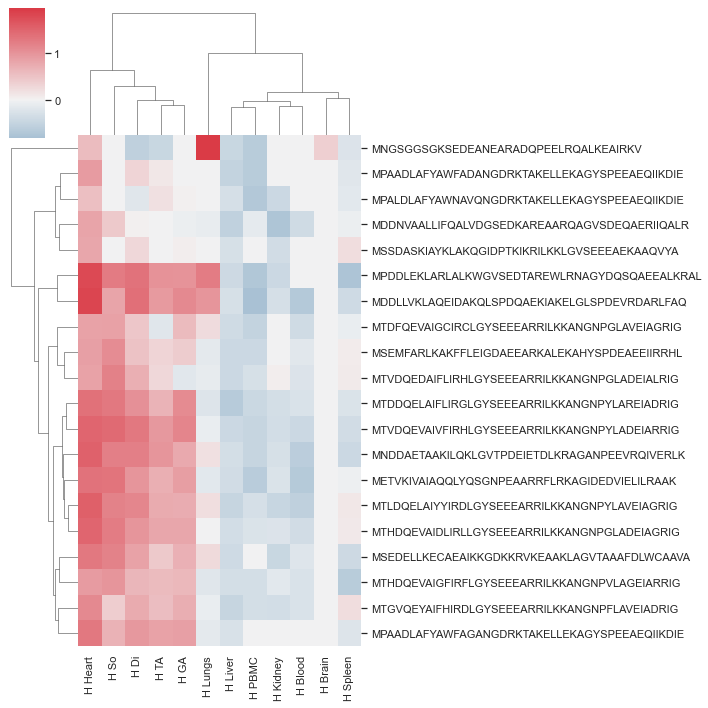

In [176]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_lisort_topy, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helhe_enrich_top_243_bottom_20_liver_clustermap.png")


In [36]:
healthy_mice_helhe_enrich_top_x_all_df_lisort_topy.index

Index(['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG',
       'MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE',
       'MTLDQELAIYYIRDLGYSEEEARRILKKANGNPYLAVEIAGRIG',
       'MTGVQEYAIFHIRDLGYSEEEARRILKKANGNPFLAVEIADRIG',
       'MSEMFARLKAKFFLEIGDAEEARKALEKAHYSPDEAEEIIRRHL',
       'MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG',
       'MTVDQEDAIFLIRHLGYSEEEARRILKKANGNPGLADEIALRIG',
       'MPDDLEKLARLALKWGVSEDTAREWLRNAGYDQSQAEEALKRAL',
       'MSEDELLKECAEAIKKGDKKRVKEAAKLAGVTAAAFDLWCAAVA',
       'MTDFQEVAIGCIRCLGYSEEEARRILKKANGNPGLAVEIAGRIG',
       'METVKIVAIAQQLYQSGNPEAARRFLRKAGIDEDVIELILRAAK',
       'MTHDQEVAIDLIRLLGYSEEEARRILKKANGNPGLADEIAGRIG',
       'MNDDAETAAKILQKLGVTPDEIETDLKRAGANPEEVRQIVERLK',
       'MTHDQEVAIGFIRFLGYSEEEARRILKKANGNPVLAGEIARRIG',
       'MDDLLVKLAQEIDAKQLSPDQAEKIAKELGLSPDEVRDARLFAQ',
       'MPAADLAFYAWFAGANGDRKTAKELLEKAGYSPEEAEQIIKDIE',
       'MNPSAAELAVRSALELGNPDAAEEFLRRANLSPEEIRRVIEEFN',
       'MTHCQECAIVYIRGLGYSEEEARRILKKANGNPLLAYEIADRIG',
       'MT

In [177]:
#healthy_mice_helhe_enrich_top_x_all_df 

healthy_mice_helhe_enrich_top_x_all_df_disort = healthy_mice_helhe_enrich_top_x_all_df.sort_values(by='H Di')

healthy_mice_helhe_enrich_top_x_all_df_disort_topy = healthy_mice_helhe_enrich_top_x_all_df_disort.head(20)

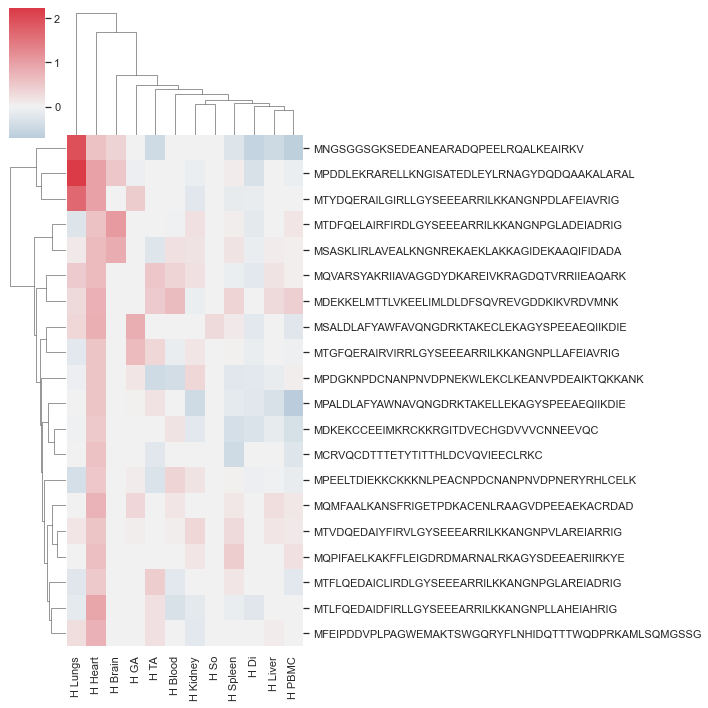

In [178]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_disort_topy, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

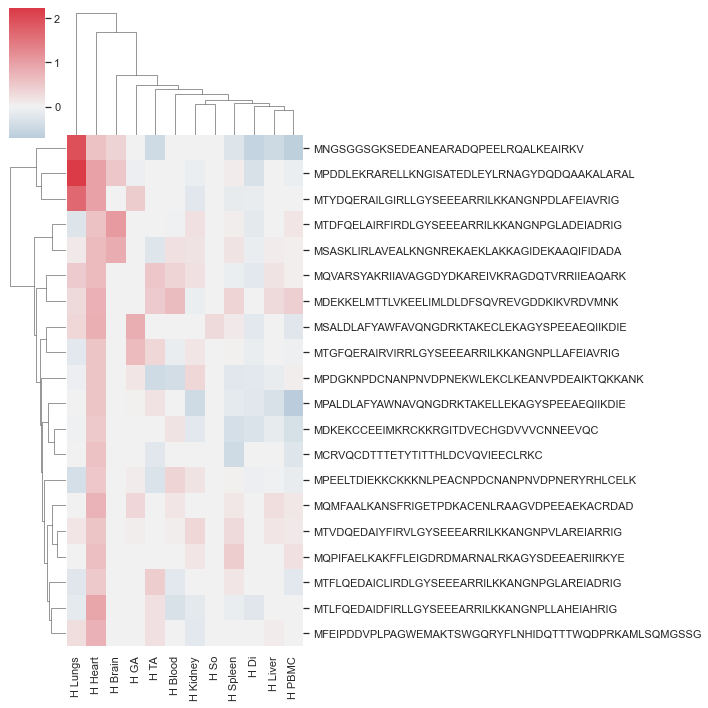

In [179]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_disort_topy, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helhe_enrich_top_243_bottom_20_dia_clustermap.png")


In [41]:
healthy_mice_helhe_enrich_top_x_all_df_disort_topy.index

Index(['MPDDLEKRARELLKNGISATEDLEYLRNAGYDQDQAAKALARAL',
       'MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG',
       'MTYDQERAILGIRLLGYSEEEARRILKKANGNPDLAFEIAVRIG',
       'MFEIPDDVPLPAGWEMAKTSSGVRYFLNHIDQTTTWQDPRKAMLSQMGSSG',
       'MREIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMGSSG',
       'MFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKADLSQMGSSG',
       'MIEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMGSSG',
       'MFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAFLSQMGSSG',
       'MFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQRTTWQDPRKAMLSQMGSSG',
       'MFEITDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMGSSG',
       'MTDVQEFAIYCIRGLGYSEEEARRILKKANGNPRLADEIACRIG',
       'MFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLRQMGSSG',
       'MPALDLAFYAWFAVQNGDRKTAKKLLEKAGYSPEEAEQIIKDIE',
       'MFEIPDDVPLPAGWEMACTSSGQRYFLNHIDQTTTWQDPRKAMLSQMGSSG',
       'MPDWDKLSCKILQLLGDDKSEIEKELRNLGVSDDIIEQCIKEES',
       'MPALDLAFYEWFAVQNGDRKTAKELLEKAGYSPEEAEQIIKDIE',
       'MSEMFARLKAKFFLEIGDTEEARKALEKAGYSWDEAEEIIRRHL',
  

In [54]:
#healthy_mice_helhe_enrich_top_x_all_df 

healthy_mice_helhe_enrich_top_x_all_df_gasort = healthy_mice_helhe_enrich_top_x_all_df.sort_values(by='H GA')

healthy_mice_helhe_enrich_top_x_all_df_gasort_topy = healthy_mice_helhe_enrich_top_x_all_df_gasort.head(20)

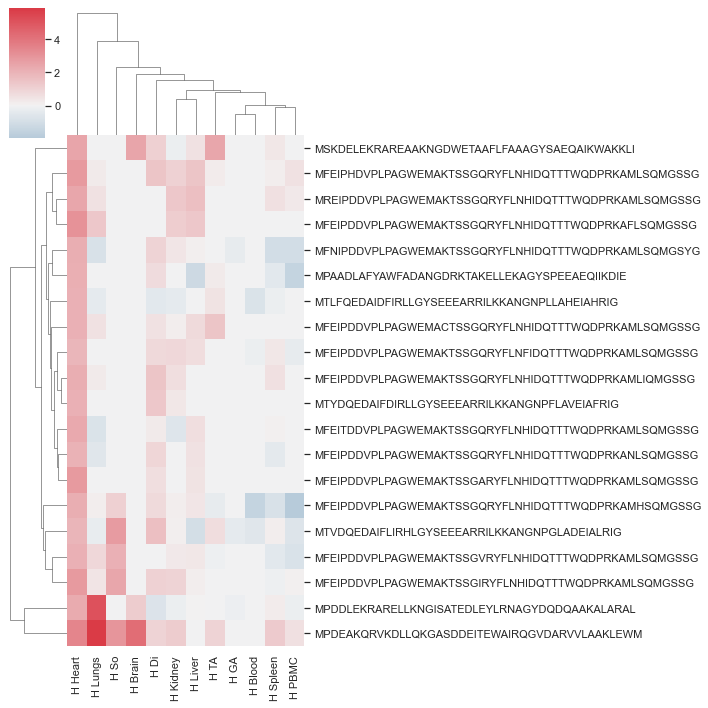

In [55]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helhe_enrich_top_x_all_df_gasort_topy, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

### *** Healthy mice heart and muscle hits *** 

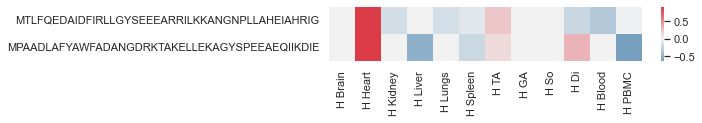

In [63]:
# get heart hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

heart_hits_df = pd.DataFrame()

heart_hits_df['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG']
heart_hits_df['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE']

heart_hits_df = heart_hits_df.T

plt.figure(figsize = (7,1))
    
heart_hits_fig = sns.heatmap(heart_hits_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

heart_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/heart_hits_fig.svg", bbox_inches="tight")
heart_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/heart_hits_fig.png", bbox_inches="tight")




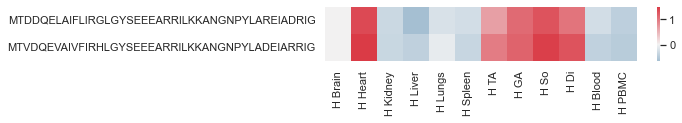

In [65]:
# get muscle hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

muscle_hits_df = pd.DataFrame()

muscle_hits_df['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG']
muscle_hits_df['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG']

muscle_hits_df = muscle_hits_df.T

plt.figure(figsize = (7,1))

muscle_hits_fig = sns.heatmap(muscle_hits_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

muscle_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/muscle_hits_fig.svg", bbox_inches="tight")
muscle_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/muscle_hits_fig.png", bbox_inches="tight")




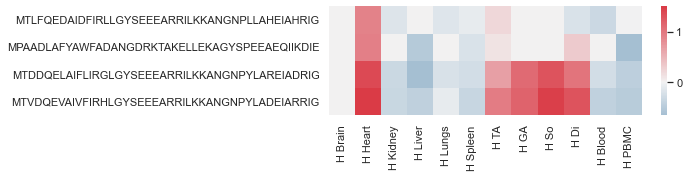

In [68]:
# get heart & muscle hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

heart_muscle_hits_df = pd.DataFrame()

heart_muscle_hits_df['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG']
heart_muscle_hits_df['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE']
heart_muscle_hits_df['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG']
heart_muscle_hits_df['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG']


heart_muscle_hits_df = heart_muscle_hits_df.T

plt.figure(figsize = (7,2))

heart_muscle_hits_fig = sns.heatmap(heart_muscle_hits_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

heart_muscle_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/heart_muscle_hits_fig.svg", bbox_inches="tight")
heart_muscle_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/heart_muscle_hits_fig.png", bbox_inches="tight")




### *** Healthy spleen vs dose ***

In [ ]:
#helsp_enrich_df

In [43]:
helsp_enrich_df = helsp_enrich_df.sort_values(by="log_enrich")
helsp_enrich_top_x_df = helsp_enrich_df.tail(208)
helsp_enrich_top_x_df

count_i  count_f  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF           10.0     32.0   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG            5.0     16.0   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI            5.0     16.0   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF            5.0     16.0   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG            5.0     16.0   
...                                                     ...      ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG           24.0    184.0   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG           26.0    202.0   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...     12.0    110.0   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL           10.0     94.0   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK            8.0    120.0   

                                                       enrich  charge    hp  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF         3.172642    0.25 -29.9   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG         3.172642   -2.00 -18.1   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI         3.172642   -1.00 -73.5   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF         3.172642    2.25 -51.8   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG         3.172642    2.00  -2.9   
...                                                       ...     ...   ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG         7.601122    0.00 -24.1   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG         7.702810    0.50 -22.6   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...   9.088298   -3.75 -55.1   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL         9.319637   -3.00 -39.1   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        14.871761    1.25 -25.2   

                                                    chg_vs_len  hp_vs_len  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF          0.005682  -0.679545   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG         -0.045455  -0.411364   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI         -0.022727  -1.670455   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF          0.051136  -1.177273   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG          0.045455  -0.065909   
...                                                        ...        ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG          0.000000  -0.547727   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG          0.011364  -0.513636   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...   -0.073529  -1.080392   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL         -0.068182  -0.888636   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK          0.028409  -0.572727   

                                                    pI at pH 7.4  log_enrich  
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF           -0.684314    0.501421  
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG           -2.728019    0.501421  
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI           -1.776377    0.501421  
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF            1.305436    0.501421  
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG            1.277839    0.501421  
...                                                          ...         ...  
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG           -0.748277    0.880878  
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG           -0.645510    0.886649  
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...     -5.540042    0.958483  
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL           -3.721685    0.969399  
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK            0.307520    1.172362  

[208 rows x 9 columns]

FileNotFoundError: [Errno 2] No such file or directory: '/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helsp_enrich_displot.png'

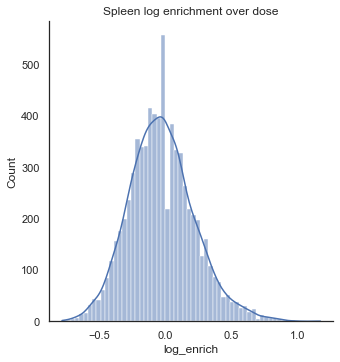

In [17]:
spleen_hist = sns.displot(data=helsp_enrich_df, x="log_enrich", kde=True).set(title='Spleen log enrichment over dose')
#spleen_hist.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helsp_enrich_displot.png")


In [152]:
limit = 0.5
# Select column 'C' from the dataframe
column = helsp_enrich_df['log_enrich']
# Get count of values greater than 20 in the column 'C' 
count = column[column > limit].count()
count

208

In [44]:
helsp_enrich_top_x_all_dict, helsp_enrich_top_x_all_df = add_all_organs_to_enrich_df(helsp_enrich_top_x_df)
healthy_mice_helsp_enrich_top_x_all_df = helsp_enrich_top_x_all_df[['H Brain', 'H Heart', 'H Kidney', 'H Liver', 'H Lungs', 'H Spleen', 'H TA', 'H GA', 'H So', 'H Di', 'H Blood', 'H PBMC']]
healthy_mice_helsp_enrich_top_x_all_df

H Brain   H Heart  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF        0.000000 -0.235693   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG        0.000000  0.645120   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI        0.000000  0.065337   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.000000  0.144518   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG        0.000000  0.366367   
...                                                      ...       ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.698192  0.132283   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.000000 -0.007214   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...  0.000000  0.328578   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.000000  0.000000   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.000000  0.000000   

                                                    H Kidney   H Liver  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF        0.395887  0.211750   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG        0.277787  0.336688   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI        0.416090  0.132568   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.520825  0.000000   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG        0.152848  0.000000   
...                                                      ...       ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.224935 -0.247643   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.105852  0.285797   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...  0.035879 -0.168462   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.187611 -0.168462   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.124820  0.007630   

                                                     H Lungs  H Spleen  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF        0.382754  0.501421   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG        0.000000  0.501421   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI        0.276299  0.501421   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.322056  0.501421   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG        0.021026  0.501421   
...                                                      ...       ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG       -0.183094  0.880878   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.003993  0.886649   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV... -0.016762  0.958483   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.299780  0.969399   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.072179  1.172362   

                                                        H TA      H GA  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF        0.245911  0.000000   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG        0.430436  0.000000   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI        0.270735  0.429180   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.015462  0.000000   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG        0.000000  0.501731   
...                                                      ...       ...   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG       -0.461659  0.250614   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.371341  0.000000   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...  0.000000  0.121519   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.316492  0.290877   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.112372  0.000000   

                                                        H So      H Di  \
MWKQPNEQWQELISATKKGNLRQAEHVAKLSAAFAAEGALKEEF        0.000000  0.000000   
MIAIDKALYLLVAEGKDKSDEAQELKGAKDDVKEAVITLRPDKG        0.000000  0.475083   
MPEEVDKLTKLLKKRNRPETDNPDCNANPNVDPNEDEYKKCQKI        0.000000  0.312356   
MTKDDLERIYQAWQEEKPITVNGTTFHKGNPKAEKALEKWKKAF        0.000000  0.000000   
MTFLQERAIVGIRYLGYSEEEARRILKKANGNPVLAYEIAVRIG        0.000000  0.549717   
...                                                  

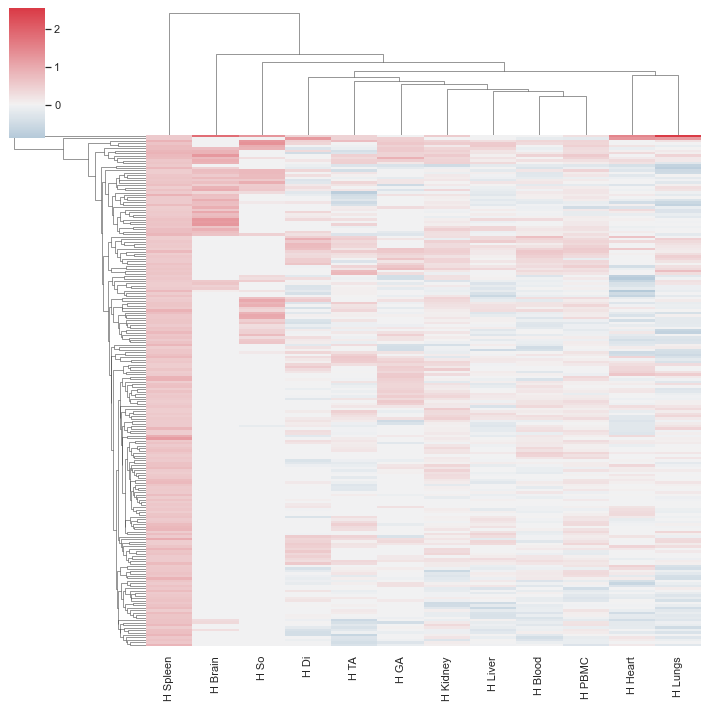

In [155]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helsp_enrich_top_x_all_df, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)

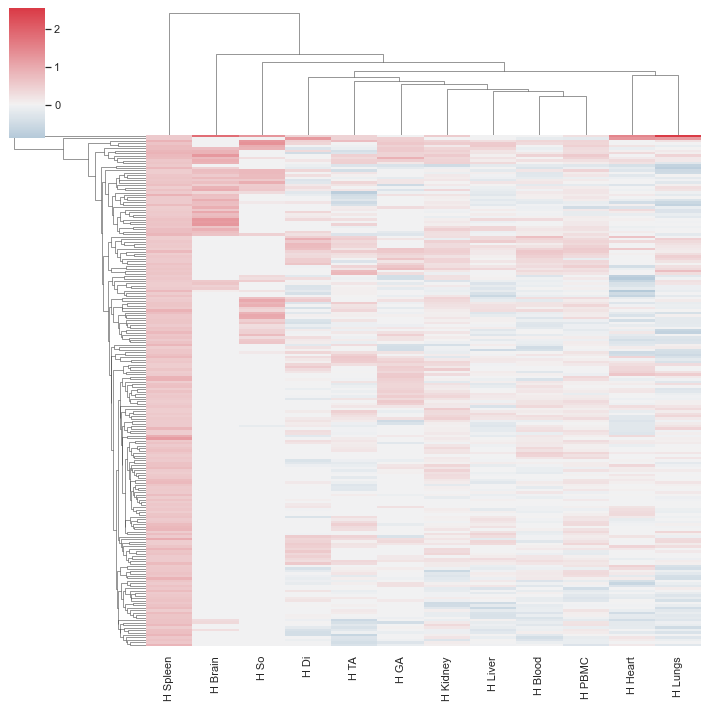

In [158]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(healthy_mice_helsp_enrich_top_x_all_df, xticklabels=True, yticklabels=False, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helsp_enrich_top_208_all_df_clustermap.png")


In [159]:
healthy_mice_helsp_enrich_top_x_all_df_spleen_sort = healthy_mice_helsp_enrich_top_x_all_df.sort_values(by="H Spleen")
healthy_mice_helsp_enrich_top_x_all_df_spleen_sort
healthy_mice_helsp_enrich_top_x_all_df_spleen_sort_20 = healthy_mice_helsp_enrich_top_x_all_df_spleen_sort.tail(20)
healthy_mice_helsp_enrich_top_x_all_df_spleen_sort_20

H Brain   H Heart  \
MTPEEYKKRAQEALKNGDEAWALALLFDAGYSVDQADEILKKLK        1.230654  0.000000   
MEQKETEKVAKAALKFGDTDFARFLLKDAGYSEEEAERIIQKFL        0.000000  0.000000   
MTDDQEVAIRYIRYLGYSEEEARRILKKANGNPYLAREIAHRIG        0.652217  0.000000   
MFDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH        0.000000 -0.207665   
MTDDEEKLKIDAALLQGNEDKAKEIAKRANVSPEEYEKLRQLAT        0.000000 -0.235693   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.000000  0.132283   
MTDEELKEAAKKLASANNNEAAKLALLAAGLSPQQVEEWLQKFH        0.000000  0.000000   
MKQVIVNGKKITVGDPKQAKELAEYFAKVYGAKVENHGETITVK        0.863789  0.065337   
MHDASYGDMDHDASYGDMDHDASYGDMDHDASYGDMDGSNSNGNGNS...  0.000000  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALNIAEKLK        0.000000  0.123328   
MIALEKWAKDTCIDDSTEVDDCPDPNANPNVDPNPDEPKIWKRN        0.000000  0.000000   
MTDEELKEAAKKLASAGNNEAAKLALLAAHLSPQQVEEWLQKFH        0.000000  0.090160   
MQLTHWHDDNQLTHWHDDNQLTHWHDDNQLTHWHDDNGSSSNSNNNS...  0.000000  0.000000   
MTDEELKHAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH        0.860130  0.330651   
MTYFQERAILYIRDLGYSEEEARRILKKANGNPDLAHEIAYRIG        0.000000 -0.110755   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.698192  0.132283   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.000000 -0.007214   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...  0.000000  0.328578   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.000000  0.000000   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.000000  0.000000   

                                                    H Kidney   H Liver  \
MTPEEYKKRAQEALKNGDEAWALALLFDAGYSVDQADEILKKLK        0.550788  0.048247   
MEQKETEKVAKAALKFGDTDFARFLLKDAGYSEEEAERIIQKFL        0.073667  0.229478   
MTDDQEVAIRYIRYLGYSEEEARRILKKANGNPYLAREIAHRIG        0.243418 -0.025040   
MFDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH       -0.403454  0.102605   
MTDDEEKLKIDAALLQGNEDKAKEIAKRANVSPEEYEKLRQLAT        0.073667 -0.168462   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.336909  0.000000   
MTDEELKEAAKKLASANNNEAAKLALLAAGLSPQQVEEWLQKFH        0.073667  0.007630   
MKQVIVNGKKITVGDPKQAKELAEYFAKVYGAKVENHGETITVK        0.464874  0.194716   
MHDASYGDMDHDASYGDMDHDASYGDMDHDASYGDMDGSNSNGNGNS...  0.198606  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALNIAEKLK        0.041483 -0.013560   
MIALEKWAKDTCIDDSTEVDDCPDPNANPNVDPNPDEPKIWKRN        0.425850  0.270871   
MTDEELKEAAKKLASAGNNEAAKLALLAAHLSPQQVEEWLQKFH       -0.202539 -0.056488   
MQLTHWHDDNQLTHWHDDNQLTHWHDDNQLTHWHDDNGSSSNSNNNS...  0.000000  0.000000   
MTDEELKHAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH        0.385978  0.215543   
MTYFQERAILYIRDLGYSEEEARRILKKANGNPDLAHEIAYRIG        0.048844 -0.081312   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.224935 -0.247643   
MTHDQEYAIVHIRDLGYSEEEARRILKKANGNPVLAFEIARRIG        0.105852  0.285797   
MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHIV...  0.035879 -0.168462   
MPQEDLAKKAAEAAKNGDTDTARELLKRAGYSEEQAEKIIQLDL        0.187611 -0.168462   
MSKVNVNNTTYTFDNPEEAAKFAKEIAKKLNLPVEVHGKEITVK        0.124820  0.007630   

                                                     H Lungs  H Spleen  \
MTPEEYKKRAQEALKNGDEAWALALLFDAGYSVDQADEILKKLK        0.403361  0.791128   
MEQKETEKVAKAALKFGDTDFARFLLKDAGYSEEEAERIIQKFL       -0.036966  0.809185   
MTDDQEVAIRYIRYLGYSEEEARRILKKANGNPYLAREIAHRIG       -0.194574  0.813520   
MFDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH        0.049055  0.815815   
MTDDEEKLKIDAALLQGNEDKAKEIAKRANVSPEEYEKLRQLAT        0.401237  0.815815   
MMHEQYPVLEMHEQYPVLEMHEQYPVLEMHEQYPVLEGGGSSNSSNG...  0.000000  0.820180   
MTDEELKEAAKKLASANNNEAAKLALLAAGLSPQQVEEWLQKFH        0.000000  0.822346   
MKQVIVNGKKITVGDPKQAKELAEYFAKVYGAKVENHGETITVK        0.137532  0.826810   
MHDASYGDMDHDASYGDMDHDASYGDMDHDASYGDMDGSNSNGNGNS...  0.000000  0.830904   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALNIAEKLK       -0.222012  0.850143   
MIALEKWAKDTCIDDSTEVDDCPDPNANPNVDPNPDEPKIWKRN        0.264064  0.864033   
MTDEELKEAAKKLASAGNNEAAKLALLAAHLSPQQVEEWLQKFH       -0.4

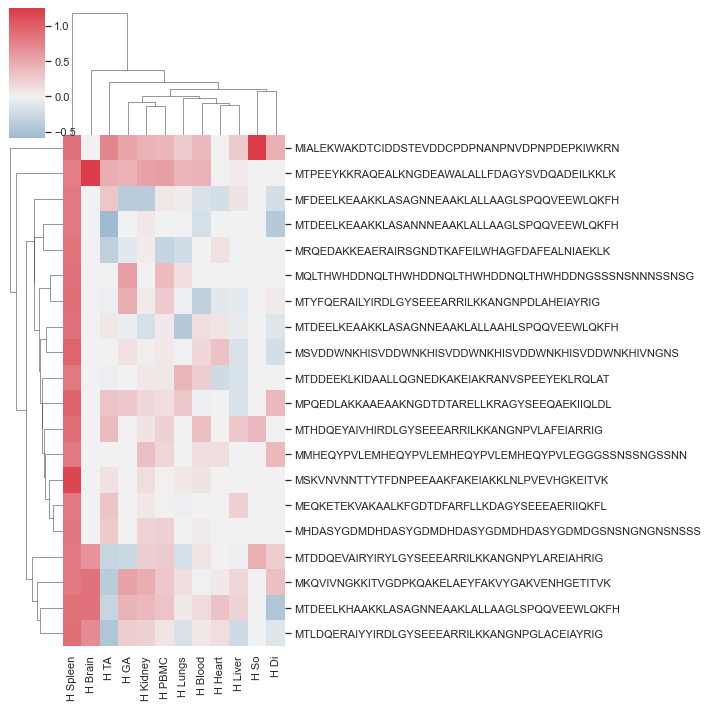

In [160]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helsp_enrich_top_x_all_df_spleen_sort_20, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

In [161]:
healthy_mice_helsp_enrich_top_x_all_df_liver_sort = healthy_mice_helsp_enrich_top_x_all_df.sort_values(by="H Liver")

In [162]:
healthy_mice_helsp_enrich_top_x_all_df_liver_sort

H Brain   H Heart  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.00000 -0.633633   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH        0.00000  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK        0.00000  0.000000   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.00000  0.000000   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.00000 -0.172024   
...                                                     ...       ...   
MSDKAKEWAEWAYKAGVDPDEVKKALKALGVSDDEADELARRLK        0.72391 -0.094364   
MEFDAQVIILDALANGISKDEARKLAKKLGLTPDKAEAALQAFS        0.00000  0.000000   
MCTEQYHCTTSEECLRIFREAVKEGKECHIDLINQQVECHC           0.00000  0.328578   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        0.00000  0.000000   
MSEDLRKAIEELLRRGINPEEIEKAAKALGYSPDEVKEALKKLG        0.00000  0.220239   

                                                    H Kidney   H Liver  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.167089 -0.566402   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH       -0.212639 -0.551678   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.059872 -0.495821   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS       -0.479175 -0.487220   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.125905 -0.368034   
...                                                      ...       ...   
MSDKAKEWAEWAYKAGVDPDEVKKALKALGVSDDEADELARRLK        0.391088  0.398836   
MEFDAQVIILDALANGISKDEARKLAKKLGLTPDKAEAALQAFS        0.249759  0.433598   
MCTEQYHCTTSEECLRIFREAVKEGKECHIDLINQQVECHC           0.441644  0.530508   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        0.520825  0.547542   
MSEDLRKAIEELLRRGINPEEIEKAAKALGYSPDEVKEALKKLG        0.131659  0.566224   

                                                     H Lungs  H Spleen  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.172794  0.662789   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH       -0.441372  0.746061   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.396509  0.607807   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.000000  0.576055   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.216335  0.636596   
...                                                      ...       ...   
MSDKAKEWAEWAYKAGVDPDEVKKALKALGVSDDEADELARRLK        0.021026  0.757389   
MEFDAQVIILDALANGISKDEARKLAKKLGLTPDKAEAALQAFS        0.062419  0.720547   
MCTEQYHCTTSEECLRIFREAVKEGKECHIDLINQQVECHC           0.322056  0.598331   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        0.000000  0.639724   
MSEDLRKAIEELLRRGINPEEIEKAAKALGYSPDEVKEALKKLG       -0.125102  0.763957   

                                                        H TA      H GA  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.015462 -0.107063   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH        0.000000  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.010867 -0.444722   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.000000 -0.010153   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.000000  0.000000   
...                                                      ...       ...   
MSDKAKEWAEWAYKAGVDPDEVKKALKALGVSDDEADELARRLK       -0.098481  0.552597   
MEFDAQVIILDALANGISKDEARKLAKKLGLTPDKAEAALQAFS        0.000000  0.000000   
MCTEQYHCTTSEECLRIFREAVKEGKECHIDLINQQVECHC           0.351254  0.000000   
MDKELAVIEAFKAIKSGNKEEARRILEEAGYSPEQAERIIRNLE        0.000000  0.591907   
MSEDLRKAIEELLRRGINPEEIEKAAKALGYSPDEVKEALKKLG       -0.051484  0.445779   

                                                        H So      H Di  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.000000  0.000000   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH        0.000000  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK        0.000000  0.029519   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.000000  0.000000   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.000000  0.052907   
...                                                      ...    

In [163]:
healthy_mice_helsp_enrich_top_x_all_df_liver_sort_bottom_20 = healthy_mice_helsp_enrich_top_x_all_df_liver_sort.head(20)
healthy_mice_helsp_enrich_top_x_all_df_liver_sort_bottom_20

H Brain   H Heart  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.000000 -0.633633   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH        0.000000  0.000000   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK        0.000000  0.000000   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.000000  0.000000   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.000000 -0.172024   
MSKTKNPDCNANPNVDPNKLNTEKCDRWERKQADLVWKEWPVT         0.000000 -0.487505   
MQPMFAELKAKFFLEIGDRDAARVALRKAGYSDEEAERIIRKYE        0.000000  0.287185   
MRQEIAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK        0.000000 -0.194301   
MQDEARKIAKELWERGETPYKIREILRKLGVDPEEAEKAVRDAD        0.000000 -0.462937   
MDESARQALEKAWRKGATEAALDAIAAQLGLSHETATRIAQKII        0.000000  0.000000   
MPRDQEDAIFYIRDLGYSEEEARRILKKANGNPYLAREIALRIG        0.630982 -0.368319   
MNDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH        0.277186  0.000000   
MDEEAKKAIKAALQQGASKDEIETEARKAGLSSSVVEQAIREWS        0.000000 -0.182448   
MNEDAEKEIRELYKNGVSPEQLQEILRRQGYNDEQVKKIVKRAI        0.000000 -0.235693   
MPEEAKKAAEKAIKAGDSPEAIKILLKSLGVSEDEAEKILRDLL        0.520433 -0.161907   
MSKLLSDKKDVREKVLLKVASKVSLKSKTENIEGLSEGSRRGST        0.000000 -0.165112   
MTDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQIFH        0.000000 -0.096031   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.698192  0.132283   
MDKEYVKLLILKAWQNNDESRLTYAADLLGVSTDTAKEIAKRLT        0.000000  0.065337   
MTPEEYKKMAQEALKNGDEAWALLLLFDAGYSVDQADEILKKLK        0.000000  0.095300   

                                                    H Kidney   H Liver  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES...  0.167089 -0.566402   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH       -0.212639 -0.551678   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.059872 -0.495821   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS       -0.479175 -0.487220   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.125905 -0.368034   
MSKTKNPDCNANPNVDPNKLNTEKCDRWERKQADLVWKEWPVT        -0.045519 -0.362282   
MQPMFAELKAKFFLEIGDRDAARVALRKAGYSDEEAERIIRKYE        0.128025 -0.344553   
MRQEIAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK        0.011519 -0.344553   
MQDEARKIAKELWERGETPYKIREILRKLGVDPEEAEKAVRDAD       -0.127248 -0.344553   
MDESARQALEKAWRKGATEAALDAIAAQLGLSHETATRIAQKII       -0.169371 -0.314590   
MPRDQEDAIFYIRDLGYSEEEARRILKKANGNPYLAREIALRIG       -0.000966 -0.301087   
MNDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH       -0.076095 -0.293400   
MDEEAKKAIKAALQQGASKDEIETEARKAGLSSSVVEQAIREWS        0.054362 -0.274917   
MNEDAEKEIRELYKNGVSPEQLQEILRRQGYNDEQVKKIVKRAI        0.027910 -0.265372   
MPEEAKKAAEKAIKAGDSPEAIKILLKSLGVSEDEAEKILRDLL       -0.056667 -0.257403   
MSKLLSDKKDVREKVLLKVASKVSLKSKTENIEGLSEGSRRGST        0.019310 -0.252783   
MTDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQIFH       -0.008520 -0.250648   
MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG        0.224935 -0.247643   
MDKEYVKLLILKAWQNNDESRLTYAADLLGVSTDTAKEIAKRLT        0.103630 -0.235408   
MTPEEYKKMAQEALKNGDEAWALLLLFDAGYSVDQADEILKKLK        0.249759 -0.235408   

                                                     H Lungs  H Spleen  \
MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.172794  0.662789   
MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH       -0.441372  0.746061   
MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.396509  0.607807   
MGKVLVNGTTYEFPDDRQALAFALELAQKLNLTITERNGVFQLS        0.000000  0.576055   
MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLES... -0.216335  0.636596   
MSKTKNPDCNANPNVDPNKLNTEKCDRWERKQADLVWKEWPVT         0.000000  0.527750   
MQPMFAELKAKFFLEIGDRDAARVALRKAGYSDEEAERIIRKYE        0.187358  0.612572   
MRQEIAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK       -0.188923  0.638076   
MQDEARKIAKELWERGETPYKIREILRKLGVDPEEAEKAVRDAD       -0.131584  0.740999   
MDESARQALEKAWRKGATEAALDAIAAQLGLSHETATRIAQKII        0.105347  0.574419   
MPRDQEDAIFYIRDLGYSEEEARRILKKANGNPYLAREIALRIG        0.189431  0.516858   
MNDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH       -0.1

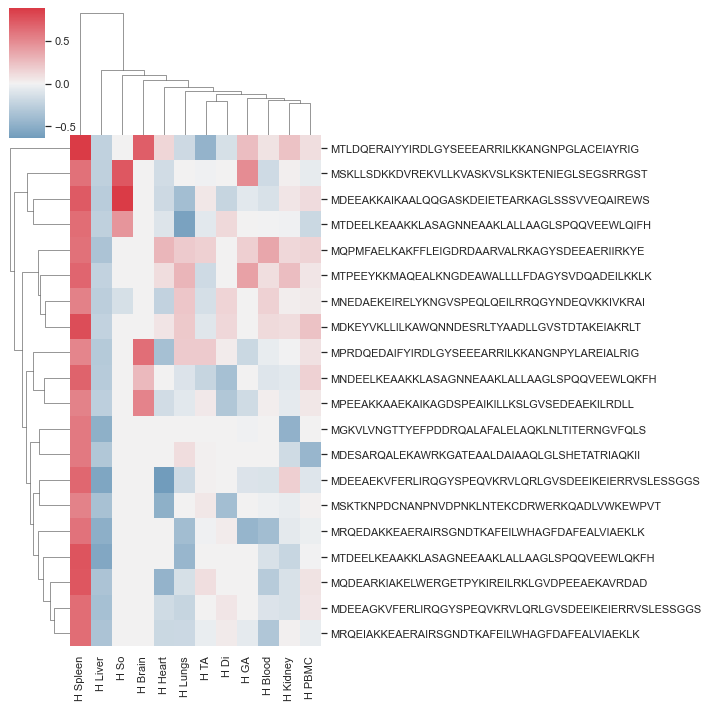

In [164]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.clustermap(healthy_mice_helsp_enrich_top_x_all_df_liver_sort_bottom_20, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)

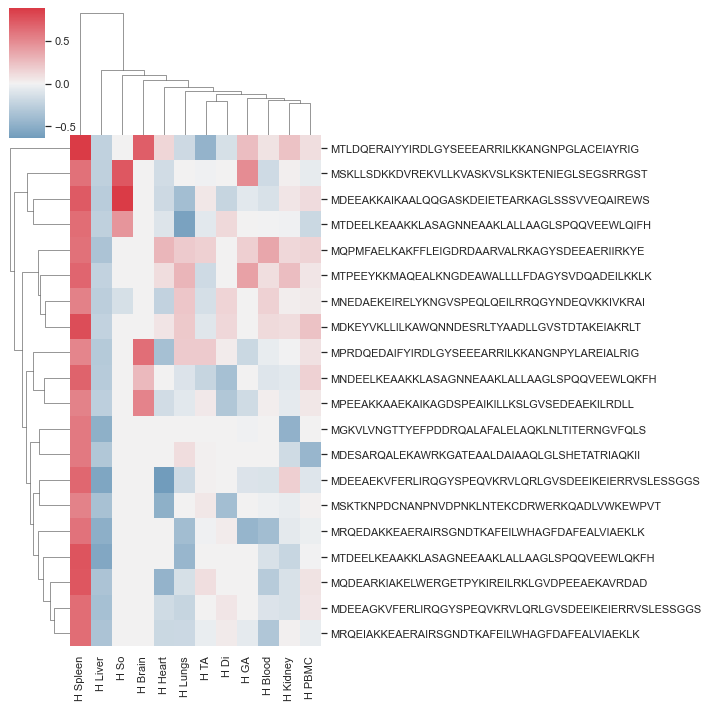

In [165]:
# SAVE CLUSTERMAP

tumor_clustermap = sns.clustermap(healthy_mice_helsp_enrich_top_x_all_df_liver_sort_bottom_20, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0)
tumor_clustermap.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_clustermaps/healthy_mice_helsp_enrich_top_208_bottom_liver_20_clustermap.png")


In [51]:
healthy_mice_helsp_enrich_top_x_all_df_liver_sort_bottom_20.index

Index(['MDEEAEKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLESSGGS',
       'MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH',
       'MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK',
       'MDEEAGKVFERLIRQGYSPEQVKRVLQRLGVSDEEIKEIERRVSLESSGGS',
       'MQDEARKIAKELWERGETPYKIREILRKLGVDPEEAEKAVRDAD',
       'MRQEIAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK',
       'MQPMFAELKAKFFLEIGDRDAARVALRKAGYSDEEAERIIRKYE',
       'MNDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFH',
       'MDEEAKKAIKAALQQGASKDEIETEARKAGLSSSVVEQAIREWS',
       'MSKLLSDKKDVREKVLLKVASKVSLKSKTENIEGLSEGSRRGST',
       'MTDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQIFH',
       'MTLDQERAIYYIRDLGYSEEEARRILKKANGNPGLACEIAYRIG',
       'MDKEYVKLLILKAWQNNDESRLTYAADLLGVSTDTAKEIAKRLT',
       'MTPEEYKKMAQEALKNGDEAWALLLLFDAGYSVDQADEILKKLK',
       'MTFLQEDAIVVIRDLGYSEEEARRILKKANGNPDLAVEIAYRIG',
       'MTDEELKEAAKKLASAGNNEAAKLALLAAGLSPQQVEEWLQKFK',
       'MPSDELLVIAFDALKNGNEDKARKLLQKAGASPEEIEKIIQKIL',
       'MSVDDWNKHISVDDWNKHISVDDWNKHISVDDWNKHISVDDWN

In [87]:
chip_seq_dict['MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH']

'tu30'

### *** Healthy spleen heatmap hits *** 

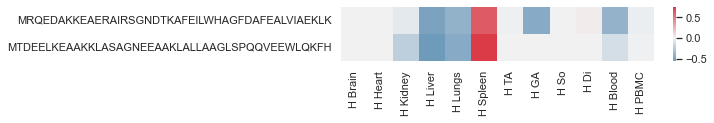

In [72]:
# get spleen hits enrichment scores as heatmap

cmap = sns.diverging_palette(240, 10, as_cmap=True)

spleen_hits_df = pd.DataFrame()

spleen_hits_df['MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK'] = healthy_mice_helsp_enrich_top_x_all_df.loc['MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK']
spleen_hits_df['MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH'] = healthy_mice_helsp_enrich_top_x_all_df.loc['MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH']

spleen_hits_df = spleen_hits_df.T

plt.figure(figsize = (7,1))

spleen_hits_fig = sns.heatmap(spleen_hits_df, xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

spleen_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/spleen_hits_fig.svg", bbox_inches="tight")
spleen_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/spleen_hits_fig.png", bbox_inches="tight")


### All healthy hits heatmap

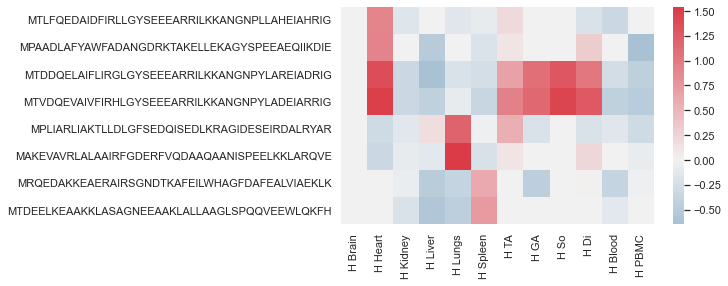

In [31]:
# get lung hits enrichment scores as heatmap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

all_healthy_hits_df = pd.DataFrame()

all_healthy_hits_df['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTLFQEDAIDFIRLLGYSEEEARRILKKANGNPLLAHEIAHRIG']
all_healthy_hits_df['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MPAADLAFYAWFADANGDRKTAKELLEKAGYSPEEAEQIIKDIE']
all_healthy_hits_df['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTDDQELAIFLIRGLGYSEEEARRILKKANGNPYLAREIADRIG']
all_healthy_hits_df['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG'] = healthy_mice_helhe_enrich_top_x_all_df.loc['MTVDQEVAIVFIRHLGYSEEEARRILKKANGNPYLADEIARRIG']

all_healthy_hits_df['MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR'] = healthy_mice_hellu_enrich_top_x_all_df.loc['MPLIARLIAKTLLDLGFSEDQISEDLKRAGIDESEIRDALRYAR']
all_healthy_hits_df['MAKEVAVRLALAAIRFGDERFVQDAAQAANISPEELKKLARQVE'] = healthy_mice_hellu_enrich_top_x_all_df.loc['MAKEVAVRLALAAIRFGDERFVQDAAQAANISPEELKKLARQVE']

all_healthy_hits_df['MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK'] = healthy_mice_helsp_enrich_top_x_all_df.loc['MRQEDAKKEAERAIRSGNDTKAFEILWHAGFDAFEALVIAEKLK']
all_healthy_hits_df['MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH'] = healthy_mice_helsp_enrich_top_x_all_df.loc['MTDEELKEAAKKLASAGNEEAAKLALLAAGLSPQQVEEWLQKFH']


all_healthy_hits_df = all_healthy_hits_df.T

plt.figure(figsize = (7,4))
    
healthy_hits_fig = sns.heatmap(all_healthy_hits_df,xticklabels=True, yticklabels=True, cmap=cmap, center=0.0).figure

healthy_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/healthy_hits.svg", bbox_inches="tight")
healthy_hits_fig.savefig("/home/audreyo/projects/mini_protein_library_seq/20220829_rd_3_seq/20220927_rd3_hits_graphs/hits_only_heatmaps/healthy_hits.png", bbox_inches="tight")
